#### GNSS Remote Sensing and Positioning

# Understanding GNSS observations

**Original by: Hans van der Marel, Modified by: Sandra Verhagen, April 2024**

In this notebook you will learn how to read and use GNSS observation data stored in RINEX files in Python and do some simple plotting with this data. The reader and tools provided by the `pdrinex` module are build upon Pythons `numpy` and `pandas` and leverage the full strength of these modules to GNSS.

## Receiver Independent Exchange Format (RINEX)

RINEX is an acronym for Receiver INdependent EXchange Format. It contains raw observation data collected by the receiver, with for each **measurement epoch**, for each **satellite**, and for each **signal** a *pseudo-range*, *carrier-phase* and *signal-to-noise ratio* measurement. The RINEX data format is used to store the raw measurement data, it is *not* for storing positions or velocities, though the RINEX file has a header which contains the *approximate position* of the receiver amongst other data such as the *marker name*, *receiver type*, *antenna type*, *antenna offset*, *observer* and other meta data. RINEX data can be created for almost any receiver, either by the receiver itself, or by a converter program from raw, and often binary, data in the receivers proprietary format.   

GNSS data has several hierarchical dimensions

**measurement epochs** 
> **satellites** 
>> **signals**
>>> **pseudo-range, carrier-phase and signal-to-noise ratio measurement**

In RINEX the different signal and measurement types are combined into a single dimension called **observation types**.

### Measurement epochs

GNSS tracking data is sampled at regular intervals, the so-called **measurement epochs** and written to file. The measurement epoch is represented by a datetime string with a resolution of 0.1 ms in the receiver time frame. This resolution is necessary because the satellites travel at about 7 km/s, so a 0.1 ms resolution in time is equivalent to 0.7 mm resolution in the satellite positions. Note that for computing the satellite positions you need to take the travel time of the signal (some 70-90 ms) into account: at the time the signal is received at the receiver the satellites has already moved more than 500 m.

### RINEX satellite and system identifiers

Receivers tracks many **satellites** simultaneously. Almost all receivers sample the satellites at the same time, so a single measurement epoch contains data for several satellites. The satellites may belong to one system (e.g. GPS) or multiple systems (GPS, Glonass, Galileo, Beidou, etc.). This has no consequences for the data storage, though for data analysis the system must be known. The satellites are identifed by a three character string,

> [System Id][2digit PRN#]    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  (examples are `G05`, `G12`, `E11`)

The first character is the identifier for the system, the other two characters is the number of the PRN code used by the satellite (or just the satellite number). System identifiers are

|System|Id|
|--|----|
|Global Positioning System GPS (USA)|G|
|Glonass (Russia)|R|
|Galileo (Europe)|E|
|Beidou (China)|C|
|Indian Regional Navigation Satellite System (IRNSS) |I|
|Quasi-Zenith Satellite System QZSS (Japan)|J|
|Satellite based augmentation system satellite (geostationary) |S|

### RINEX observation types

The receiver tracks several **signals**. Different signals may be transmitted on the same or different **frequencies**. For each signal the receiver tracks the code modulation and phase of the signal, resulting in measurements of **pseudo-range** [meters], **carrier-phase** [cycles] and **signal-to-noise ratio** [dB or dB-Hz]. The measurement for signal-to-noise ratio is often a **carrier-to-noise** measurement [dB-Hz]. The receiver may also track the Doppler shift [Hz], which can be given as an additional measurement. The type of signal and measurement are combined into **observation types**, which are characterized by a three letter abbreviation,

> [type][freq][attribute]   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  (examples are `C1C`, `L2W`, `S1C`)

with

* [type] the measurement type: `C`=pseudo range [m], `L`=carrier phase [cycles], `D`=doppler [Hz],  `S`=signal strength [dB-Hz]
* [freq] the signal frequency code: `1`=L1/G1, `2`=L2/G2, `5`=L5/E5a, `6`=E6, `7`=E5b, `8`=E5 (E5a+E5b)
* [attribute] an attribute specifying the signal and tracking mode, e.g. `C` for standard code tracking, `W` for P-W tracking of the P-code signals, `X` for tracking both a pilot and data signal. 

Note that the receiver may track different signals on the same frequency, so it is not uncommon to find for example both a `_2W` and `_2X` for the same satellite (with `_` one of `C`, `L` or `S`).

The frequencies and signal that are tracked depend on the system. The signals that are tracked are listed in the RINEX file header for each system. Within a system, different generations of satellites exist, and older satellites may not provide all the signals that more recent satellites have. Furthermore, it depends on the receiver which signal types are actually tracked, and receiver manufacturers tend to make different choices.

### RINEX file naming and compression

A RINEX file contains multiple epochs, usually sampled at regular intervals. Common intervals are 30 sec for daily files and 1 sec for highrate files, but also other interval or fractions of seconds are possible. It is also common to sample at integers of seconds (then all 7 decimals of the second are zero). Data is stored often in daily files with 15 or 30 sec sample rate, hourly files with 10, 15 or 30 second sample rate, and/or high-rate data with 1 second sample rate in files with 15 minute intervals. The sampling rate is specified in the RINEX file header, but the interval and period is also reflected in the recommended RINEX file naming convention

>  [NNNN][##][CCC] _ [R] _ [YYYYDDDHHMM] _ [##P] _ [##S] _ [MO].rnx  &nbsp;&nbsp;&nbsp;&nbsp;    (example `DLF100NLD_R_20171130000_01D_30S_MO.rnx`) <br>
>  [NNNN][##][CCC] _ [R]  _ [YYYYDDDHHMM] _ [##P] _ [##S] _ [MO] .rnx.gz   
>  [NNNN][##][CCC] _ [R] _ [YYYYDDDHHMM] _ [##P] _ [##S] _ [MO].crx.gz      

with 

* **name** [NNNN][##][CCC], defining the site (4 characters with letters and digits [NNNN]), station (2 digits [##]) and country (International country code [CCC]), 
* **start time**  [YYYYDDDHHMM], with year [YYYY], day of year [DDD], hour [HH] and minute [MM]
* nominal file **period** [##P], with two digits for the duration, followed by `D` for days, `H` for hours, or `M` for minutes
* **sample rate** [##S], with two digits for the sample period, followed by `S` for seconds (or `M`)

and [R] and identifier for receiver ([R]=`R`) or stream data ([R]=`S`), and [MO] the file type, with ([MO]=`MO`) for mixed observations (other possibilities are `GO`, `EO`, etc. for one system only observations.


The file extension is either `rnx` for uncompressed files, `rnx.gz` for `gzip` compressed files, and `crx.gz` for double compressed files, using first the so-called Hatanaka compression, followed by `gzip`. `gzip` compression is supported standard on most systems. For the Hatanaka decompression you have to used a small commandline tool `crx2rnx` to do the decompression (https://terras.gsi.go.jp/ja/crx2rnx.html).

For RINEX3 navigation files, which contains the broadcast satellite ephemerides data, a slightly different format is used

>  [NNNN][##][CCC] _ [R] _ [YYYYDDDHHMM] _ [##P] _ [MN].rnx  &nbsp;&nbsp;&nbsp;&nbsp;    (example `DLF100NLD_R_20171130000_01D_MN.rnx`)
>  [NNNN][##][CCC] _ [R]  _ [YYYYDDDHHMM] _ [##P] _ [MN] .rnx.gz

Notice the different identifier for the file type, the absence of the sample rate field, and option for Hatanaka compression (crx).  

Tracking data for many GNSS receivers is available on the Internet as open access. For this demo we will use data from the Netherlands provided by the TU Delft from http://gnss1.tudelft.nl/dpga .  


For this Jupyter notebook to work, the Jupyter notebook should be in the same folder as the two modules. Import the modules using the following statements:

## Getting started

First thing to do is to import the `numpy` and `pandas` modules. Then, download the `pdrinex` module, put `pdrinex.py` into your working directory, and import the function we need from this module.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [114]:
from pdrinex import rnxReadObs, rnxPrintMetadata, rnxSelSys,rnxGetUnits, rnxGetFreqs

You can use standard `help()` to get more information on each function. We do this for `rnxReadObs`, for the other functions it will become clear from the examples.

In [115]:
help(rnxReadObs)

Help on function rnxReadObs in module pdrinex:

rnxReadObs(rnxFilename: str, verbose: int = 0) -> (<class 'pandas.core.frame.DataFrame'>, <class 'dict'>, <class 'list'>)
    Read RINEX observation data from file.
    
    Parameters
    ----------
    rnxFilename : str
        RINEX observation filename
    verbose : int, default=0
        Verbosity level (0 is no output, 1 some, 2 more)
    
    Returns
    -------
    rnxDf : pandas.DataFrame
        Pandas multi index dataframe with the RINEX observations. The RINEX meta data, timestamps and other
        data are stored as attributes in the data frame (rnxDf.attrs).
        
    Raises
    ------
    ValueError
        If the file is not a RINEX observation file 
        If the RINEX observation file is other than a version 3 file (version 2 files not yet supported)
        If the time stamps are not strictly ascending or when there are duplicates
        If there are invalid satellite identifiers
    
    Notes
    -----
    Meta 

## Download RINEX data


First, we have to download some data. We are going to download a RINEX observation file for the IGS (International GNSS Service) station in Delft. The data is available from http://gnss1.tudelft.nl/dpga/rinex, and is stored in daily directories. For instance, data of 14 April 2021 can be found in http://gnss1.tudelft.nl/dpga/2021/104, where 104 is the day of year number. The name of the station is `DLF100NLD`, the compressed RINEX observation file for 14 April 2021 is called `DLF100NLD_R_20211040000_01D_30S_MO.crx.gz` (see the previous section).

**WHEN YOU HAVE ALREADY DOWNLOADED THE DATA, SKIP THE NEXT CELLS TO THE LAST CELL OF THIS SECTION,  TO SELECT JUST A FILENAME.**

To download the data we can use the `requests` module in Python. 

In [4]:
import requests
import os

#crxFilename = 'DLF100NLD_R_20171130000_01D_30S_MO.crx.gz'
#crxFilename = 'ZEGV00NLD_R_20211040000_01D_30S_MO.crx.gz'
crxFilename = ''

print('Compressed RINEX observation file:', crxFilename)

url='http://gnss1.tudelft.nl/dpga/rinex/' + crxFilename[12:16] + '/' + crxFilename[16:19] + '/' + crxFilename
print('Download URL:',url)

r = requests.get(url)
with open(crxFilename, 'wb') as f:
    f.write(r.content)
    
print('Status code (should be 200):',r.status_code)
print('Compressed file size:',os.path.getsize(crxFilename),' Bytes')

Compressed RINEX observation file: DLF100NLD_R_20211040000_01D_30S_MO.crx.gz
Download URL: http://gnss1.tudelft.nl/dpga/rinex/2021/104/DLF100NLD_R_20211040000_01D_30S_MO.crx.gz
Status code (should be 200): 200
Compressed file size: 2364102  Bytes


If this doesn't work for you, just download the file using your favorite browser and make sure to save it to your working directory.

The next step is to decompress the data. For this we are going to use `rnxUnpack` from the `rnxio` module. This module will download `crx2rnx` from https://terras.gsi.go.jp/ja/crx2rnx.html and use it together with `gzip` to uncompress the RINEX file. 

In [5]:
from rnxio import rnxUnpack

# rnxFilename = rnxUnpack(crxFilename)                  # for Windows users
rnxFilename = rnxUnpack(crxFilename, sys='darwin')   # for Mac users

print('Compressed file size:',"{:.2f}".format(os.path.getsize(crxFilename)/1024/1024),' Mb')
print('Uncompressed file size:',"{:.2f}".format(os.path.getsize(rnxFilename)/1024/1024),' Mb')
print('Compression ratio:',"{:.2f}".format(os.path.getsize(rnxFilename)/os.path.getsize(crxFilename)))

Using crx2rnx executable from RNXCMP_4.1.0_MacOSX10.14_gcc/bin/CRX2RNX
Compressed file size: 2.25  Mb
Uncompressed file size: 19.11  Mb
Compression ratio: 8.48


The compressed file size is about 2.3 Mb, compared to the uncompressed file size of 19.2 Mb. Generally, compressed RINEX files are 8-9 times smaller than the uncompressed files.

*The decompression module `rnxio` is still a bit experimental. If it doesn't work for you you can also download the RINEX file directly from Brightspace. If you have downloaded the data from Brightspace, or restart this notebook, and have the data already available, you can skip the previous steps and set RINEX filename directly in the next code segment.*

**CONTINUE HERE WHEN YOU HAVE ALREADY DOWNLOADED THE DATA...**

In [1]:
# Set RINEX file name (in case the data is already available on disk) - do not execute when you have downloaded the data

if not 'rnxFilename' in locals():
    #rnxFilename = 'rinex135/NORG00NLD_R_20221350000_01D_15S_MO.rnx'
    #rnxFilename = 'rinex135/NOR300NLD_R_20221350000_01D_15S_MO.rnx'
    rnxFilename = 'rinex135/RDN100NLD_R_20221350000_01D_15S_MO.rnx'
    
    
print(rnxFilename)

rinex135/RDN100NLD_R_20221350000_01D_15S_MO.rnx


In [116]:
rnxFilename_NORG = 'rinex135/NORG00NLD_R_20221350000_01D_15S_MO.rnx'
rnxFilename_NOR3 = 'rinex135/NOR300NLD_R_20221350000_01D_15S_MO.rnx'
rnxFilename_RDN1 = 'rinex135/RDN100NLD_R_20221350000_01D_15S_MO.rnx'

## Read RINEX data 

The RINEX data is read using the `rnxReadObs` into a pandas **DataFrame**.  

In [117]:
rnxDf_RDN1 = rnxReadObs(rnxFilename_RDN1, verbose=1)
rnxDf_NOR3 = rnxReadObs(rnxFilename_NOR3, verbose=1)
rnxDf_NORG = rnxReadObs(rnxFilename_NORG, verbose=1)

RINEX type and version: OBS 3.0
Header fields: dict_keys(['RINEX VERSION / TYPE', 'PGM / RUN BY / DATE', 'COMMENT', 'OBSERVER / AGENCY', 'REC # / TYPE / VERS', 'ANT # / TYPE', 'ANTENNA: DELTA H/E/N', 'MARKER NAME', 'MARKER NUMBER', 'MARKER TYPE', 'APPROX POSITION XYZ', 'WAVELENGTH FACT L1/2', 'TIME OF FIRST OBS', 'TIME OF LAST OBS', 'INTERVAL', 'SYS / # / OBS TYPES', '# / TYPES OF OBSERV', '# OF SATELLITES', 'PRN / # OF OBS'])
Observation types:
G ['C1C', 'L1C', 'D1C', 'S1C', 'C1W', 'C2W', 'L2W', 'D2W', 'S2W']
Maximum number of observation types 9
done reading rinex observation file
pandas observation data frame ready
RINEX type and version: OBS 3.0
Header fields: dict_keys(['RINEX VERSION / TYPE', 'PGM / RUN BY / DATE', 'COMMENT', 'OBSERVER / AGENCY', 'REC # / TYPE / VERS', 'ANT # / TYPE', 'ANTENNA: DELTA H/E/N', 'MARKER NAME', 'MARKER NUMBER', 'MARKER TYPE', 'APPROX POSITION XYZ', 'WAVELENGTH FACT L1/2', 'TIME OF FIRST OBS', 'TIME OF LAST OBS', 'INTERVAL', 'SYS / # / OBS TYPES', '# /

Pandas is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language. The DataFrame, a fast and efficient object for data manipulation with integrated indexing, is what we use to store and manipulate the data. It inherits a lot of the functionality from `numpy` and `matplotlib` for plotting.  If you haven't worked with pandas before, please have a look at one of these resources

* https://pandas.pydata.org/docs/getting_started/index.html#
* https://pandas.pydata.org/docs/user_guide/index.html

For starters, to get some info on the data we can use pandas `info()` and/or `describe()` methods.

In [118]:
rnxDf_RDN1.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 53359 entries, (Timestamp('2022-05-15 00:00:00'), 'G11') to (Timestamp('2022-05-15 23:59:45'), 'G30')
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       53359 non-null  float64
 1   1       53359 non-null  float64
 2   2       53359 non-null  float64
 3   3       53359 non-null  float64
 4   4       53226 non-null  float64
 5   5       53229 non-null  float64
 6   6       53229 non-null  float64
 7   7       53229 non-null  float64
 8   8       53229 non-null  float64
dtypes: float64(9)
memory usage: 3.9+ MB


Try out `rnxDf.describe()` yourself.

The meta data, mostly derived from the RINEX file header, is stored as attributes (dictionary) in `rnxDf.attrs`. To pretty print the meta data use the `rnxPrintMetadata` function provided by `pdrinex`

In [119]:
rnxPrintMetadata(rnxDf_RDN1)

version :  3.0
rnxtype :  OBS
systems :  G
marker :  rdn1 (rdn1)
rectype :  TPS NET-G5
anttype :  TPSCR.G5        TPSH
interval :  15.0
timerange :  (Timestamp('2022-05-15 00:00:00'), Timestamp('2022-05-15 23:59:45'))
timesystem :  GPS
position :  (3810307.0353, 430714.6966, 5079699.8391)
antoffset :  (0.0, 0.0, 0.0)
obsTypes : 
    G : ['C1C', 'L1C', 'D1C', 'S1C', 'C1W', 'C2W', 'L2W', 'D2W', 'S2W']
maxTypes :  9
isregular :  True
hasgaps :  False
maxgap :  None
numepochs :  5760
expected :  5760
missing :  0
epochTimestamps :  [Timestamp('2022-05-15 00:00:00') Timestamp('2022-05-15 00:00:15')
 Timestamp('2022-05-15 00:00:30') ... Timestamp('2022-05-15 23:59:15')
 Timestamp('2022-05-15 23:59:30') Timestamp('2022-05-15 23:59:45')]
epochFlags :  ['0' '0' '0' ... '0' '0' '0']
epochNumSats :  [8 8 8 ... 8 8 8]
events :  []
satIds :  ['G01' 'G02' 'G03' 'G04' 'G05' 'G06' 'G07' 'G08' 'G09' 'G10' 'G11' 'G12'
 'G13' 'G14' 'G15' 'G16' 'G17' 'G18' 'G19' 'G20' 'G21' 'G22' 'G23' 'G24'
 'G25' 'G26' 

In [53]:
rnxPrintMetadata(rnxDf_NOR3)

version :  3.0
rnxtype :  OBS
systems :  G
marker :  nor3 (nor3)
rectype :  TPS NET-G5
anttype :  TPSCR.G5        TPSH
interval :  15.0
timerange :  (Timestamp('2022-05-15 00:00:00'), Timestamp('2022-05-15 23:59:45'))
timesystem :  GPS
position :  (3812821.9964, 427864.2848, 5078068.5463)
antoffset :  (0.0, 0.0, 0.0)
obsTypes : 
    G : ['C1C', 'L1C', 'D1C', 'S1C', 'C1W', 'C2W', 'L2W', 'D2W', 'S2W']
maxTypes :  9
isregular :  True
hasgaps :  False
maxgap :  None
numepochs :  5760
expected :  5760
missing :  0
epochTimestamps :  [Timestamp('2022-05-15 00:00:00') Timestamp('2022-05-15 00:00:15')
 Timestamp('2022-05-15 00:00:30') ... Timestamp('2022-05-15 23:59:15')
 Timestamp('2022-05-15 23:59:30') Timestamp('2022-05-15 23:59:45')]
epochFlags :  ['0' '0' '0' ... '0' '0' '0']
epochNumSats :  [10 10 10 ... 10 10 10]
events :  []
satIds :  ['G01' 'G02' 'G03' 'G04' 'G05' 'G06' 'G07' 'G08' 'G09' 'G10' 'G11' 'G12'
 'G13' 'G14' 'G15' 'G16' 'G17' 'G18' 'G19' 'G20' 'G21' 'G22' 'G23' 'G24'
 'G25' 

You can also use `print(rnxDf.attrs`), but this tends to give a lot output and is not very practical. To retrieve specific attributes you can use syntax `value = rnxDf.attrs['key']`. For example, to print the observation types, do

In [120]:
rnxPrintMetadata(rnxDf_NORG)

version :  3.0
rnxtype :  OBS
systems :  G
marker :  norg (norg)
rectype :  TPS NETG3
anttype :  TPSCR.G5        TPSH
interval :  15.0
timerange :  (Timestamp('2022-05-15 00:00:00'), Timestamp('2022-05-15 23:59:45'))
timesystem :  GPS
position :  (3814549.2529, 429958.8559, 5076615.8097)
antoffset :  (0.097, 0.0, 0.0)
obsTypes : 
    G : ['C1C', 'L1C', 'D1C', 'S1C', 'C1W', 'C2W', 'L2W', 'D2W', 'S2W']
maxTypes :  9
isregular :  True
hasgaps :  False
maxgap :  None
numepochs :  5760
expected :  5760
missing :  0
epochTimestamps :  [Timestamp('2022-05-15 00:00:00') Timestamp('2022-05-15 00:00:15')
 Timestamp('2022-05-15 00:00:30') ... Timestamp('2022-05-15 23:59:15')
 Timestamp('2022-05-15 23:59:30') Timestamp('2022-05-15 23:59:45')]
epochFlags :  ['0' '0' '0' ... '0' '0' '0']
epochNumSats :  [ 9  9  9 ... 10 10 10]
events :  []
satIds :  ['G01' 'G02' 'G03' 'G04' 'G05' 'G06' 'G07' 'G08' 'G09' 'G10' 'G11' 'G12'
 'G13' 'G14' 'G15' 'G16' 'G17' 'G18' 'G19' 'G20' 'G21' 'G22' 'G23' 'G24'
 'G25'

In [121]:
print(rnxDf_RDN1.attrs['obsTypes'])
print(rnxDf_NOR3.attrs['obsTypes'])
print(rnxDf_NORG.attrs['obsTypes'])

{'G': ['C1C', 'L1C', 'D1C', 'S1C', 'C1W', 'C2W', 'L2W', 'D2W', 'S2W']}
{'G': ['C1C', 'L1C', 'D1C', 'S1C', 'C1W', 'C2W', 'L2W', 'D2W', 'S2W']}
{'G': ['C1C', 'L1C', 'D1C', 'S1C', 'C1W', 'C2W', 'L2W', 'D2W', 'S2W']}


## Understanding what is in the pdrinex DataFrame

To see what is inside of a DataFrame can type the variable name, or use the `print()` or `head()` functions of Python. Note that the output of `print()` is slightly different than from typing the variable name

In [122]:
rnxDf_RDN1  

0             1         2     3  \
TimeStamp           SatId                                               
2022-05-15 00:00:00 G11    2.301606e+07  1.209502e+08 -2572.163  46.0   
                    G07    2.100681e+07  1.103916e+08  -242.327  50.0   
                    G09    2.314355e+07  1.216203e+08 -2772.434  45.0   
                    G02    2.378175e+07  1.249740e+08 -2141.123  46.0   
                    G13    2.334542e+07  1.226810e+08  3503.720  45.0   
...                                 ...           ...       ...   ...   
2022-05-15 23:59:45 G02    2.374115e+07  1.247606e+08 -2298.018  44.0   
                    G05    2.156548e+07  1.133274e+08  2402.179  50.0   
                    G11    2.299599e+07  1.208448e+08 -2740.796  46.0   
                    G07    2.088413e+07  1.097469e+08  -438.699  48.0   
                    G30    2.087691e+07  1.097089e+08  1469.685  51.0   

                                      4             5             6         7  \
TimeStamp           SatId                                                       
2022-05-15 00:00:00 G11    2.301606e+07  2.301606e+07  9.424694e+07 -2004.283   
                    G07    2.100681e+07  2.100681e+07  8.601944e+07  -188.826   
                    G09    2.314355e+07  2.314356e+07  9.476909e+07 -2160.338   
                    G02    2.378175e+07  2.378175e+07  9.738231e+07 -1668.408   
                    G13    2.334542e+07  2.334542e+07  9.559557e+07  2730.171   
...                                 ...           ...           ...       ...   
2022-05-15 23:59:45 G02    2.374115e+07  2.374115e+07  9.721607e+07 -1790.663   
                    G05    2.156548e+07  2.156548e+07  8.830709e+07  1871.828   
                    G11    2.299599e+07  2.299599e+07  9.416479e+07 -2135.685   
                    G07    2.088413e+07  2.088413e+07  8.551711e+07  -341.844   
                    G30    2.087690e+07  2.087691e+07  8.548751e+07  1145.209   

                              8  
TimeStamp           SatId        
2022-05-15 00:00:00 G11    36.0  
                    G07    54.0  
                    G09    47.0  
                    G02    35.0  
                    G13    31.0  
...                         ...  
2022-05-15 23:59:45 G02    33.0  
                    G05    43.0  
                    G11    35.0  
                    G07    54.0  
                    G30    56.0  

[53359 rows x 9 columns]

The structure is very similar to how the data is stored in the RINEX file. 

Each row contains the observations for a single satellite at a specific measurement epoch. At a single measurement epochs, multiple satellites are observed. Therefore, for the rows a double index is used. The first index is the measurement epoch and is called *TimeStamp*, the second index is the satellite id and is called *SatId*.

The columns are named `0, 1, 2 ...`, each representing a different observation type. We used abstract column names because we cannot yet associate each column with a specific observation type, as the observation types are different for each system, given in the attribute `rnxDf.attrs['obsTypes']`. 

Furthermore, there are a lot of large values, not surprisingly since the satellites are at 20,000 km altitude. But there are also `NaN` when there are no measurements, which happens especially for the columns to the right. This is also not a surprise, considering that we have different number of observation types for each system.

Since the number and type of observations are different for each system, and each column of `rnxDf` can contains different observation types (though the same for each system), it makes sense to do our analysis system by system.

The `pdrinex` module provides very convenient functions for selecting data from one system or one satellite.

## Selecting data for a single system

To select data for a single system, e.g. GPS, use the `rnxSelSys()` function.

In [123]:
gpsDf_stacked_RDN1 = rnxSelSys(rnxDf_RDN1,'G')
gpsDf_stacked_RDN1

ObsType                             C1C           L1C       D1C   S1C  \
TimeStamp           SatId                                               
2022-05-15 00:00:00 G11    2.301606e+07  1.209502e+08 -2572.163  46.0   
                    G07    2.100681e+07  1.103916e+08  -242.327  50.0   
                    G09    2.314355e+07  1.216203e+08 -2772.434  45.0   
                    G02    2.378175e+07  1.249740e+08 -2141.123  46.0   
                    G13    2.334542e+07  1.226810e+08  3503.720  45.0   
...                                 ...           ...       ...   ...   
2022-05-15 23:59:45 G02    2.374115e+07  1.247606e+08 -2298.018  44.0   
                    G05    2.156548e+07  1.133274e+08  2402.179  50.0   
                    G11    2.299599e+07  1.208448e+08 -2740.796  46.0   
                    G07    2.088413e+07  1.097469e+08  -438.699  48.0   
                    G30    2.087691e+07  1.097089e+08  1469.685  51.0   

ObsType                             C1W           C2W           L2W       D2W  \
TimeStamp           SatId                                                       
2022-05-15 00:00:00 G11    2.301606e+07  2.301606e+07  9.424694e+07 -2004.283   
                    G07    2.100681e+07  2.100681e+07  8.601944e+07  -188.826   
                    G09    2.314355e+07  2.314356e+07  9.476909e+07 -2160.338   
                    G02    2.378175e+07  2.378175e+07  9.738231e+07 -1668.408   
                    G13    2.334542e+07  2.334542e+07  9.559557e+07  2730.171   
...                                 ...           ...           ...       ...   
2022-05-15 23:59:45 G02    2.374115e+07  2.374115e+07  9.721607e+07 -1790.663   
                    G05    2.156548e+07  2.156548e+07  8.830709e+07  1871.828   
                    G11    2.299599e+07  2.299599e+07  9.416479e+07 -2135.685   
                    G07    2.088413e+07  2.088413e+07  8.551711e+07  -341.844   
                    G30    2.087690e+07  2.087691e+07  8.548751e+07  1145.209   

ObsType                     S2W  
TimeStamp           SatId        
2022-05-15 00:00:00 G11    36.0  
                    G07    54.0  
                    G09    47.0  
                    G02    35.0  
                    G13    31.0  
...                         ...  
2022-05-15 23:59:45 G02    33.0  
                    G05    43.0  
                    G11    35.0  
                    G07    54.0  
                    G30    56.0  

[53359 rows x 9 columns]

In [124]:
gpsDf_stacked_NOR3 = rnxSelSys(rnxDf_NOR3,'G')
gpsDf_stacked_NOR3

ObsType                             C1C           L1C       D1C   S1C  \
TimeStamp           SatId                                               
2022-05-15 00:00:00 G11    2.286205e+07  1.201409e+08 -1936.039  45.0   
                    G14    2.524696e+07  1.326737e+08  4523.474  39.0   
                    G13    2.319195e+07  1.218745e+08  4137.186  43.0   
                    G09    2.299594e+07  1.208446e+08 -2137.543  45.0   
                    G20    2.041502e+07  1.072817e+08  1245.477  50.0   
...                                 ...           ...       ...   ...   
2022-05-15 23:59:45 G20    2.053726e+07  1.079241e+08   757.777  49.0   
                    G30    2.100819e+07  1.103989e+08  1846.307  51.0   
                    G16    2.520569e+07  1.324568e+08 -2214.351  35.0   
                    G13    2.318500e+07  1.218380e+08  3761.127  45.0   
                    G07    2.101763e+07  1.104485e+08   -62.168  49.0   

ObsType                             C1W           C2W           L2W       D2W  \
TimeStamp           SatId                                                       
2022-05-15 00:00:00 G11    2.286205e+07  2.286205e+07  9.361633e+07 -1508.602   
                    G14    2.524696e+07  2.524696e+07  1.033821e+08  3524.785   
                    G13    2.319195e+07  2.319195e+07  9.496719e+07  3223.781   
                    G09    2.299594e+07  2.299594e+07  9.416464e+07 -1665.618   
                    G20    2.041502e+07  2.041502e+07  8.359617e+07   970.502   
...                                 ...           ...           ...       ...   
2022-05-15 23:59:45 G20    2.053726e+07  2.053726e+07  8.409672e+07   590.475   
                    G30    2.100819e+07  2.100820e+07  8.602513e+07  1438.681   
                    G16    2.520569e+07  2.520570e+07  1.032131e+08 -1725.468   
                    G13    2.318500e+07  2.318500e+07  9.493875e+07  2930.748   
                    G07    2.101763e+07  2.101763e+07  8.606379e+07   -48.443   

ObsType                     S2W  
TimeStamp           SatId        
2022-05-15 00:00:00 G11    34.0  
                    G14    21.0  
                    G13    29.0  
                    G09    47.0  
                    G20    44.0  
...                         ...  
2022-05-15 23:59:45 G20    44.0  
                    G30    56.0  
                    G16    18.0  
                    G13    29.0  
                    G07    54.0  

[57776 rows x 9 columns]

As you can see, the column numbers have been replaced by appropriate observation types. 

There are still some `NaN`'s in the data, this is because there are several generations of GPS satellites, and only newer generations provide the so-called modernized signals. 

A little more worrying is that this data is not easy to plot. If you try, you may get unexpected results. This is because of the multi-index in the rows. 

To facilitate plotting it is wise to unstack the data, this can be done in `rnxSelSys` by giving the optional parameter `unstack=True`

In [125]:
gpsDf_stacked_NORG = rnxSelSys(rnxDf_NORG,'G')
gpsDf_stacked_NORG

ObsType                             C1C           L1C       D1C   S1C  \
TimeStamp           SatId                                               
2022-05-15 00:00:00 G11    2.288870e+07  1.202810e+08 -1757.533  45.0   
                    G05    2.168905e+07  1.139768e+08  3404.764  51.0   
                    G07    2.088358e+07  1.097441e+08   566.358  51.0   
                    G16    2.497919e+07  1.312665e+08 -1593.187  40.0   
                    G13    2.322026e+07  1.220233e+08  4313.819  45.0   
...                                 ...           ...       ...   ...   
2022-05-15 23:59:45 G20    2.047116e+07  1.075767e+08  1303.379  50.0   
                    G09    2.320157e+07  1.219252e+08 -1971.609  44.0   
                    G14    2.515294e+07  1.321796e+08  4740.073  40.0   
                    G07    2.095037e+07  1.100951e+08   480.576  49.0   
                    G05    2.163216e+07  1.136779e+08  3326.960  49.0   

ObsType                             C1W           C2W           L2W       D2W  \
TimeStamp           SatId                                                       
2022-05-15 00:00:00 G11    2.288870e+07  2.288870e+07  9.372544e+07 -1369.506   
                    G05    2.168905e+07  2.168905e+07  8.881310e+07  2653.063   
                    G07    2.088358e+07  2.088358e+07  8.551488e+07   441.318   
                    G16    2.497919e+07  2.497918e+07  1.022856e+08 -1241.444   
                    G13    2.322025e+07  2.322025e+07  9.508310e+07  3361.417   
...                                 ...           ...           ...       ...   
2022-05-15 23:59:45 G20    2.047116e+07  2.047116e+07  8.382605e+07  1015.620   
                    G09    2.320156e+07  2.320157e+07  9.500663e+07 -1536.319   
                    G14    2.515294e+07  2.515293e+07  1.029971e+08  3693.563   
                    G07    2.095037e+07  2.095037e+07  8.578837e+07   374.475   
                    G05    2.163216e+07  2.163216e+07  8.858016e+07  2592.436   

ObsType                     S2W  
TimeStamp           SatId        
2022-05-15 00:00:00 G11    34.0  
                    G05    42.0  
                    G07    54.0  
                    G16    16.0  
                    G13    28.0  
...                         ...  
2022-05-15 23:59:45 G20    43.0  
                    G09    44.0  
                    G14    19.0  
                    G07    53.0  
                    G05    42.0  

[60619 rows x 9 columns]

In [126]:
gpsDf_RDN1 = rnxSelSys(rnxDf_RDN1, 'G', unstack=True)
gpsDf_RDN1

SatId               G01                                           G02  ...  \
ObsType             C1C C1W C2W D1C D2W L1C L2W S1C S2W           C1C  ...   
TimeStamp                                                              ...   
2022-05-15 00:00:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.378175e+07  ...   
2022-05-15 00:00:15 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.378787e+07  ...   
2022-05-15 00:00:30 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.379401e+07  ...   
2022-05-15 00:00:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.380017e+07  ...   
2022-05-15 00:01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.380636e+07  ...   
...                  ..  ..  ..  ..  ..  ..  ..  ..  ..           ...  ...   
2022-05-15 23:58:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.371501e+07  ...   
2022-05-15 23:59:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.372152e+07  ...   
2022-05-15 23:59:15 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.372805e+07  ...   
2022-05-15 23:59:30 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.373460e+07  ...   
2022-05-15 23:59:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.374115e+07  ...   

SatId               G31 G32                                  
ObsType             S2W C1C C1W C2W D1C D2W L1C L2W S1C S2W  
TimeStamp                                                    
2022-05-15 00:00:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 00:00:15 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 00:00:30 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 00:00:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 00:01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
...                  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  
2022-05-15 23:58:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 23:59:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 23:59:15 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 23:59:30 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 23:59:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[5760 rows x 288 columns]

In [127]:
gpsDf_NOR3 = rnxSelSys(rnxDf_NOR3, 'G', unstack=True)
gpsDf_NOR3

SatId               G01                                           G02  ...  \
ObsType             C1C C1W C2W D1C D2W L1C L2W S1C S2W           C1C  ...   
TimeStamp                                                              ...   
2022-05-15 00:00:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.362767e+07  ...   
2022-05-15 00:00:15 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.363198e+07  ...   
2022-05-15 00:00:30 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.363629e+07  ...   
2022-05-15 00:00:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.364062e+07  ...   
2022-05-15 00:01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.364497e+07  ...   
...                  ..  ..  ..  ..  ..  ..  ..  ..  ..           ...  ...   
2022-05-15 23:58:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.384788e+07  ...   
2022-05-15 23:59:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.385330e+07  ...   
2022-05-15 23:59:15 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.385873e+07  ...   
2022-05-15 23:59:30 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.386418e+07  ...   
2022-05-15 23:59:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.386965e+07  ...   

SatId               G31 G32                                  
ObsType             S2W C1C C1W C2W D1C D2W L1C L2W S1C S2W  
TimeStamp                                                    
2022-05-15 00:00:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 00:00:15 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 00:00:30 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 00:00:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 00:01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
...                  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  
2022-05-15 23:58:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 23:59:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 23:59:15 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 23:59:30 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 23:59:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[5760 rows x 288 columns]

The columns are now a combination of *SatId* and *ObsType*, using a multi index. The rows are indexed by the timestamps. 

Unstacking the data eliminates also any unobserved observation type, but also introduces new `NaN`'s at timestamps where GPS satellites are unobserved. Unstacking the data requires about twice the storage, as we can see from `info()`.

In [128]:
gpsDf_NORG = rnxSelSys(rnxDf_NORG, 'G', unstack=True)
gpsDf_NORG

SatId               G01                                           G02  ...  \
ObsType             C1C C1W C2W D1C D2W L1C L2W S1C S2W           C1C  ...   
TimeStamp                                                              ...   
2022-05-15 00:00:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.365474e+07  ...   
2022-05-15 00:00:15 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.365853e+07  ...   
2022-05-15 00:00:30 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.366234e+07  ...   
2022-05-15 00:00:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.366617e+07  ...   
2022-05-15 00:01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.367001e+07  ...   
...                  ..  ..  ..  ..  ..  ..  ..  ..  ..           ...  ...   
2022-05-15 23:58:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.378779e+07  ...   
2022-05-15 23:59:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.379166e+07  ...   
2022-05-15 23:59:15 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.379554e+07  ...   
2022-05-15 23:59:30 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.379944e+07  ...   
2022-05-15 23:59:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.380335e+07  ...   

SatId               G31 G32                                  
ObsType             S2W C1C C1W C2W D1C D2W L1C L2W S1C S2W  
TimeStamp                                                    
2022-05-15 00:00:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 00:00:15 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 00:00:30 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 00:00:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 00:01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
...                  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  
2022-05-15 23:58:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 23:59:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 23:59:15 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 23:59:30 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 23:59:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[5760 rows x 288 columns]

In [129]:
gpsDf_stacked.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 60619 entries, (Timestamp('2022-05-15 00:00:00'), 'G11') to (Timestamp('2022-05-15 23:59:45'), 'G05')
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   C1C     60619 non-null  float64
 1   L1C     60619 non-null  float64
 2   D1C     60619 non-null  float64
 3   S1C     60619 non-null  float64
 4   C1W     60565 non-null  float64
 5   C2W     60565 non-null  float64
 6   L2W     60565 non-null  float64
 7   D2W     60565 non-null  float64
 8   S2W     60565 non-null  float64
dtypes: float64(9)
memory usage: 4.4+ MB


## Part 1: Selecting satellites, observation types and plotting

Plotting the data is easy, but you have to be selective in the amount of data to plot. In this section we explain how to select one or more satellites, and/or one or more observations types, and how to plot these selections.

Simple selections are fairly intuitive, but more advanced selections require the `.loc()` or `.iloc()` method and to specify an `axis` to work on. 

We let the examples speak for themselves.

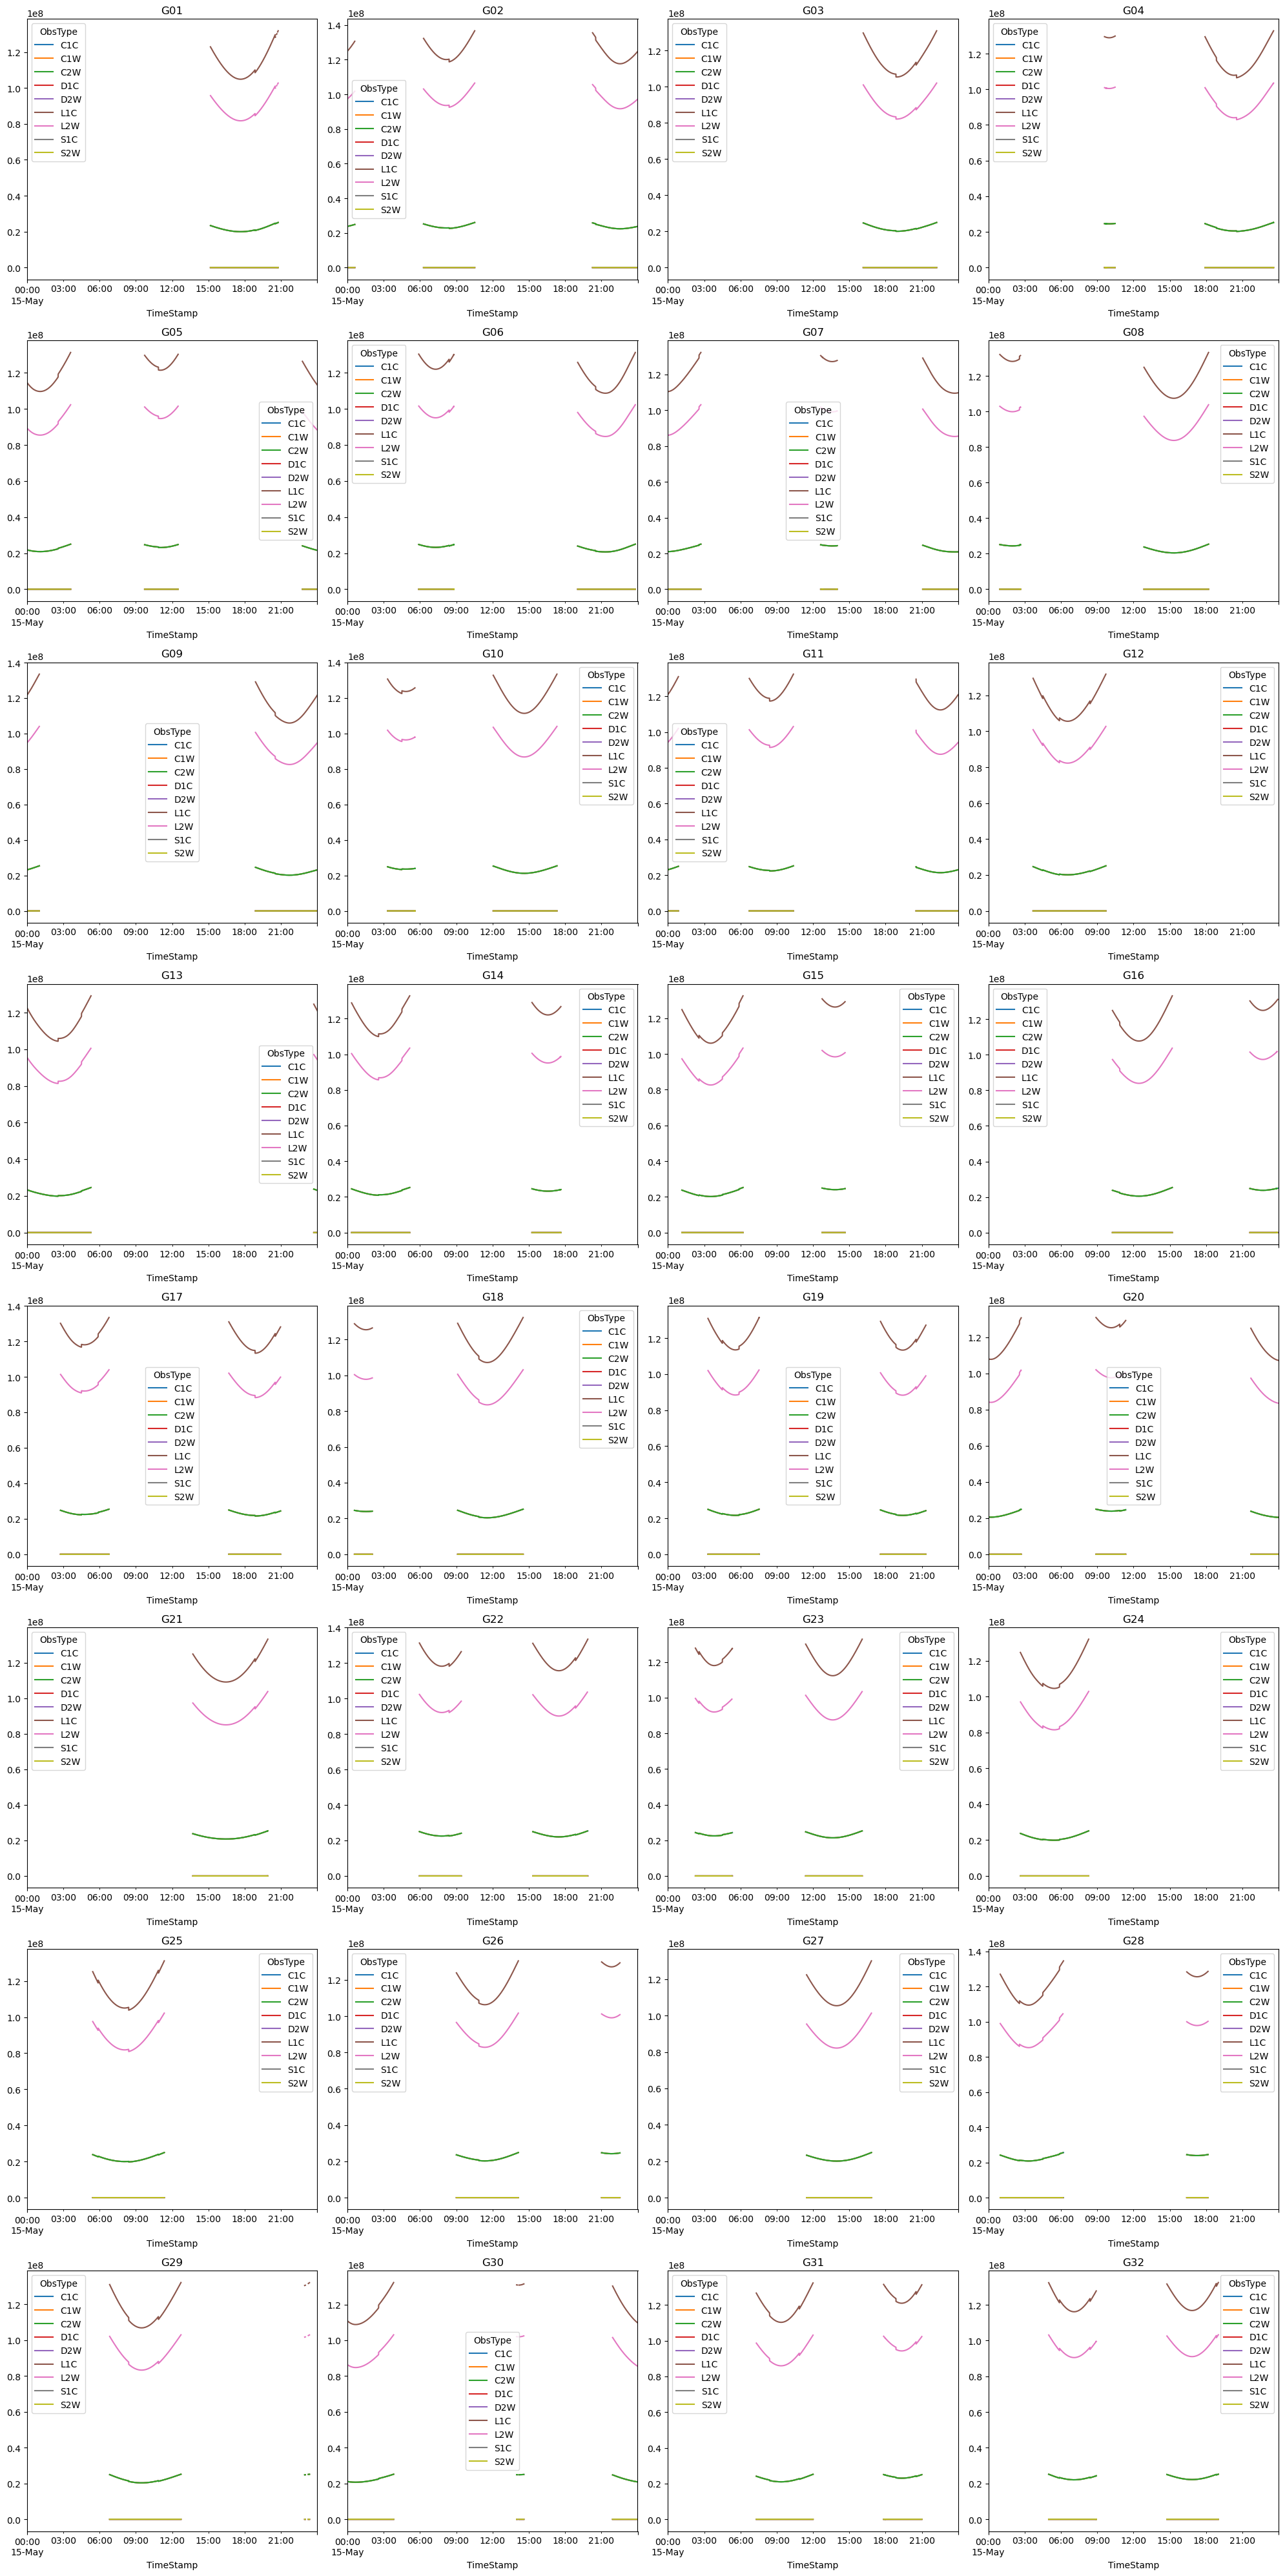

In [71]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 40))  # Adjust the size as needed
axes = axes.flatten()  # Flatten the 2D array of axes to easily iterate

# Plot each satellite's data
for i in range(32):
    satellite = f'G{i+1:02d}'  # Create the satellite name G01, G02, ..., G32
    if satellite in gpsDf_RDN1.columns:
        gpsDf_RDN1[satellite].plot(ax=axes[i])
        axes[i].set_title(satellite)
    else:
        axes[i].set_visible(False)  # Hide the subplot if the satellite data is not available

# Adjust layout
plt.tight_layout()
plt.show()


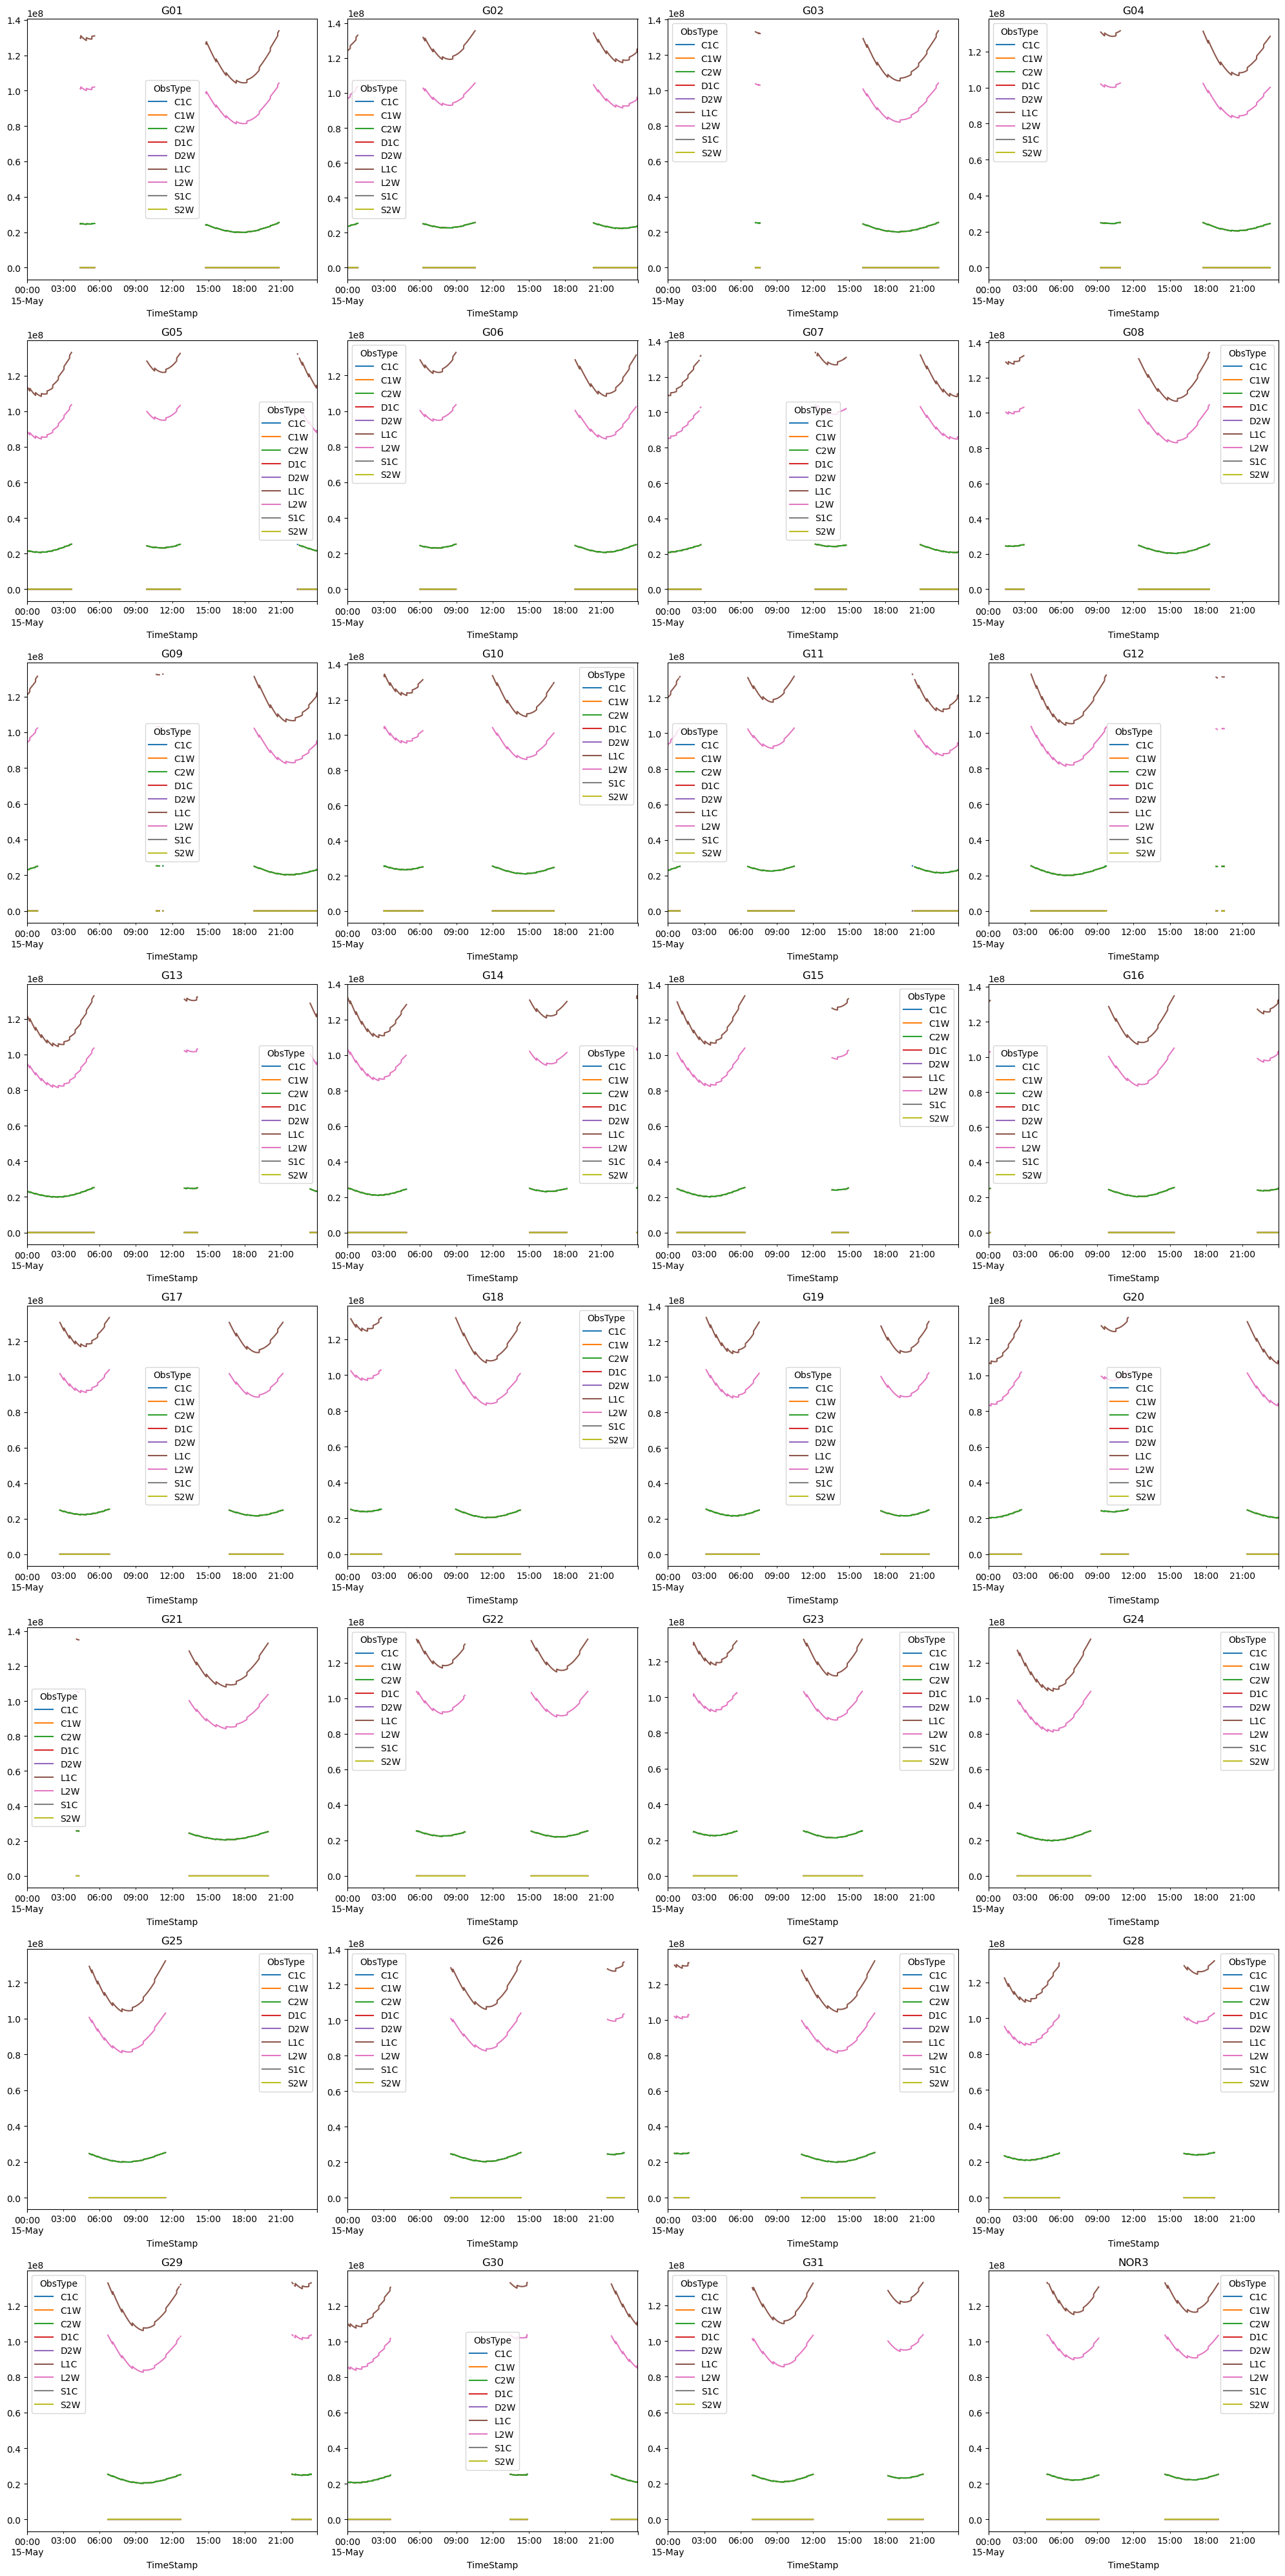

In [72]:

# Create a figure with subplots
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 40))  # Adjust the size as needed
axes = axes.flatten()  # Flatten the 2D array of axes to easily iterate

# Plot each satellite's data
for i in range(32):
    satellite = f'G{i+1:02d}'  # Create the satellite name G01, G02, ..., G32
    if satellite in gpsDf_NOR3.columns:
        gpsDf_NOR3[satellite].plot(ax=axes[i])
        axes[i].set_title(satellite)
    else:
        axes[i].set_visible(False)  # Hide the subplot if the satellite data is not available

# Adjust layout
plt.title('NOR3')
plt.tight_layout()
plt.show()


Start and end times are easy to specify

In [25]:
tfirst=pd.Timestamp('2022-05-15 11:00')
tlast=pd.Timestamp('2022-05-15 13:00')

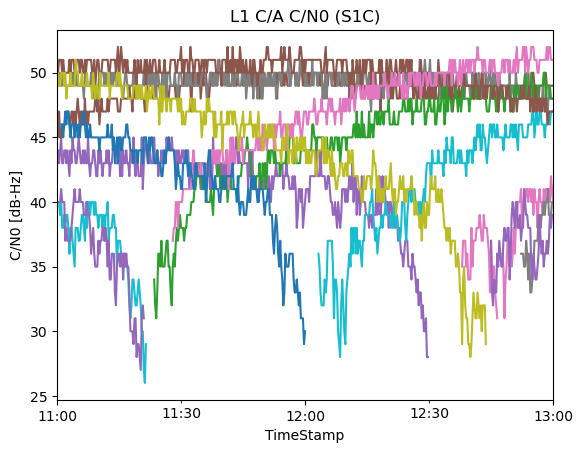

In [26]:
ax=gpsDf.loc(axis=0)[tfirst:tlast].loc(axis=1)[:,'S1C'].plot(legend=None)
ax.set_ylabel('C/N0 [dB-Hz]')
ax.set_title('L1 C/A C/N0 (S1C)');

You are not limited to time series plot. Sometimes it is even better to use the stacked DataFrame instead of the unstacked DataFrame. For example, to investigate the relation between the carrier-to-noise ratios you can do something like this.

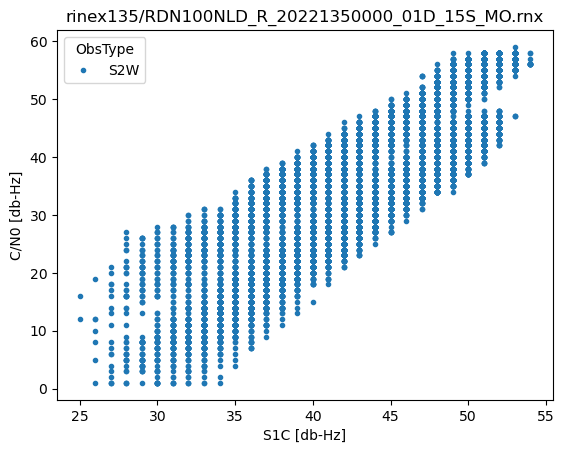

In [131]:
ax = gpsDf_stacked_RDN1.plot(x='S1C', y=['S2W'], style='.')

ax.set_title(gpsDf_stacked_RDN1.attrs['rnxFilename'])
ax.set_xlabel('S1C [db-Hz]')
ax.set_ylabel('C/N0 [db-Hz]');
#ax.axes.set_aspect('equal');

# Part 2: taking differences of observations

Let's repeat two of the plots of the pseudo-range and carrier-phase observations.

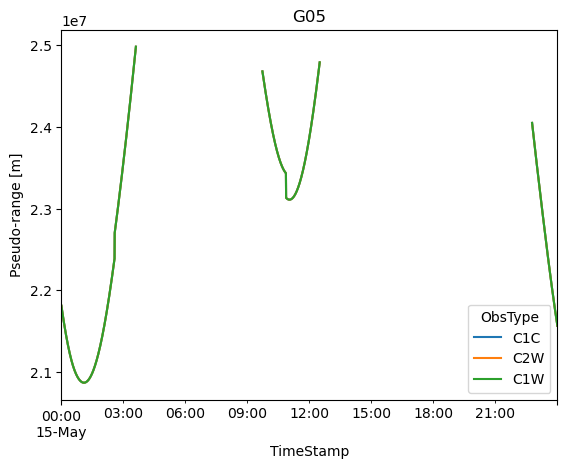

In [132]:
ax=gpsDf_RDN1['G05'][['C1C', 'C2W', 'C1W']].plot()
ax.set_ylabel('Pseudo-range [m]')
ax.set_title('G05');

All satellites with S2W


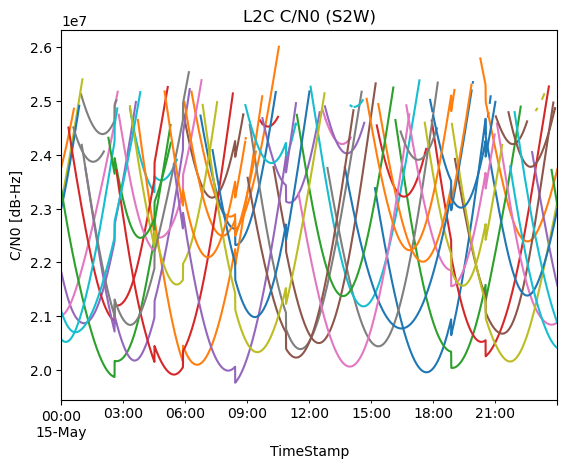

In [133]:
ax=gpsDf_RDN1.loc(axis=1)[:,'C2W'].plot(legend=None)
ax.set_ylabel('C/N0 [dB-Hz]')
ax.set_title('L2C C/N0 (S2W)')
print("All satellites with S2W")

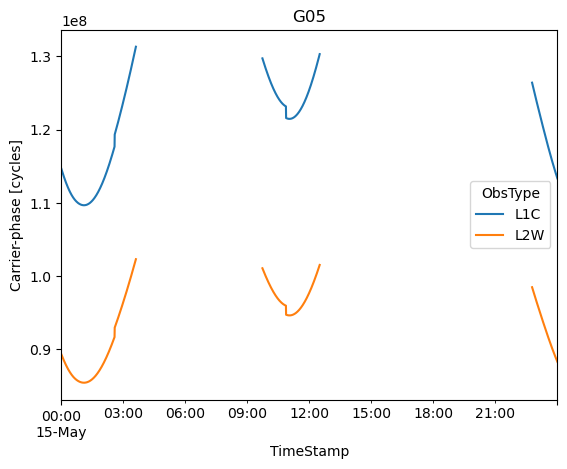

In [35]:
ax=gpsDf['G05'][['L1C', 'L2W']].plot()
ax.set_ylabel('Carrier-phase [cycles]')
ax.set_title('G05');

In the plot of the three pseudo-ranges (`C__`), which have units of meters, all signals are plotted over each other and look like a single curve. For the carrier phase (`L__`), which have units of cycles, plots are not overlaid for different frequencies and because of **arbitrary** initial phase ambiguities.

In order to see the differences we have two task at hand

* Multiply the carrier-phase with the wavelength of the signal (to obtain units of meters)
* Take differences between signals to actually see what the differences are

For the first task we need the frequency of the signals, which we will deal with later.

We start with taking differences (simple linear combinations) of the pseudo-ranges for which we don't need the frequencies.

## Differences between observations types

You can do ordinary math on pandas DataFrames as long as you respect the rules of `numpy` and Python. Meaning, `*` and `/` is element wise multiplication and division, and `@` is shorthand for matrix multiplication.

To take the difference between `C2W` and `C1C` for GPS `G05`, and plotting, is as simple as

In [134]:
lc = gpsDf_RDN1['G05']['C2W'] - gpsDf_RDN1['G05']['C1C']
print(lc.dropna(how='all'))
print(type(lc))

TimeStamp
2022-05-15 00:00:00   -0.705
2022-05-15 00:00:15   -0.464
2022-05-15 00:00:30   -0.793
2022-05-15 00:00:45   -0.661
2022-05-15 00:01:00   -0.927
                       ...  
2022-05-15 23:58:45   -0.530
2022-05-15 23:59:00   -0.470
2022-05-15 23:59:15   -0.425
2022-05-15 23:59:30   -0.412
2022-05-15 23:59:45   -0.483
Length: 1827, dtype: float64
<class 'pandas.core.series.Series'>


The result is a pandas Series object, which is the one dimensional equivalent of a pandas DataFrame, and ideal for plotting time series.

The `.dropna(how='all')` in the print statement is used to remove rows with all `NaN`'s. For plotting we want to leave the `NaN`'s in, because these generate a break in the line.

To plot the time series use the `.plot()` method

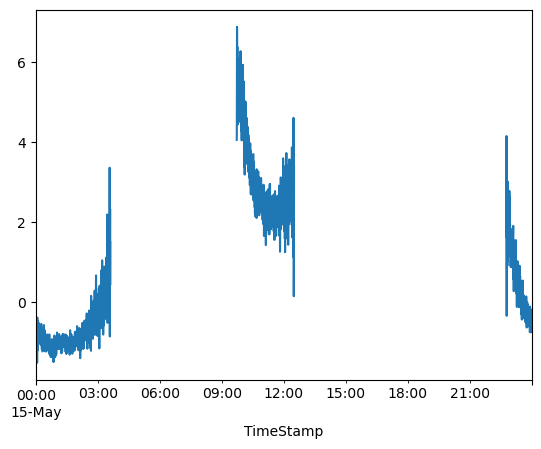

In [135]:
ax=lc.plot()
ax.set_title='G05 RDN1'
ax.set_ylabel='C2W-C1C [m]'

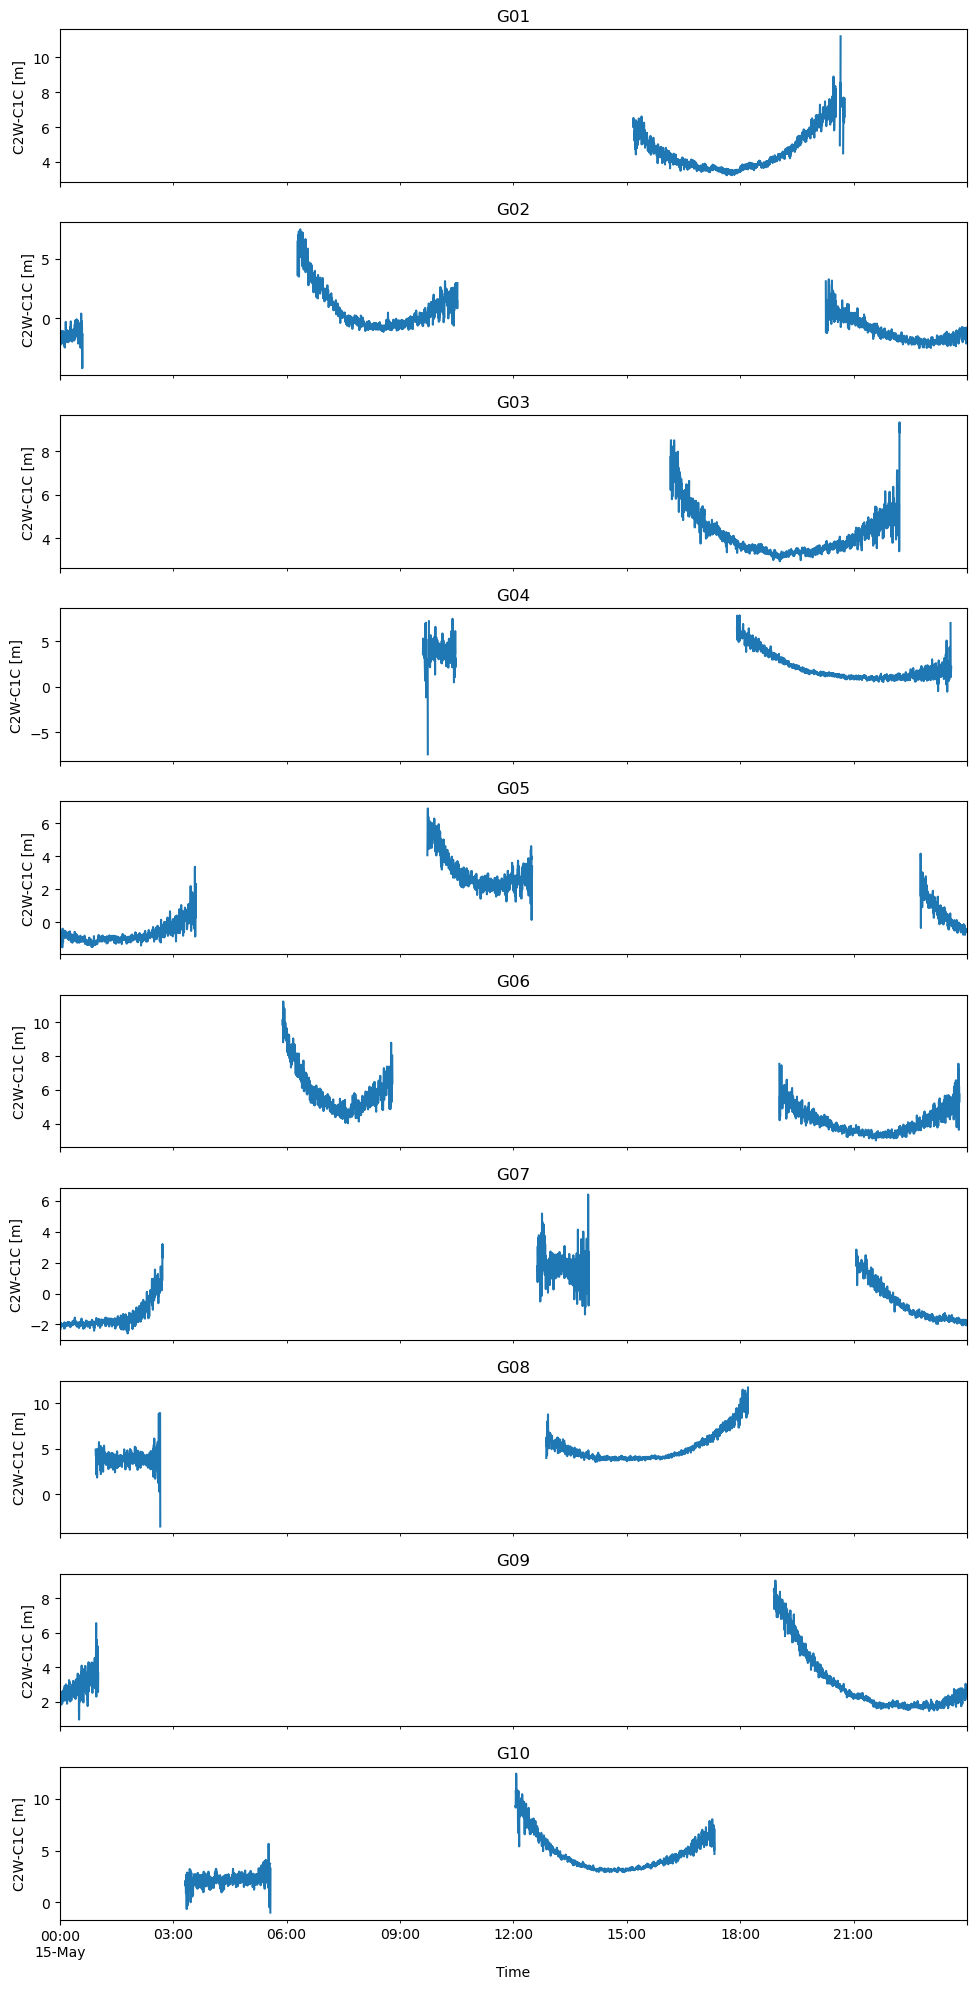

In [136]:

# Assuming gpsDf is your DataFrame with the satellite data
# gpsDf = pd.read_csv('your_file.csv')  # Load your data if it's not already in memory

fig, axs = plt.subplots(10, 1, figsize=(10, 20), sharex=True)

for i in range(1, 11):
    satellite = f'G{i:02d}'  # Generates satellite names G01, G02, ..., G10
    lc = gpsDf_RDN1[satellite]['C2W'] - gpsDf_RDN1[satellite]['C1C']
    
    
    ax = axs[i - 1]
    lc.plot(ax=ax)
    ax.set_title(f'{satellite}')
    ax.set_ylabel('C2W-C1C [m]')

# Add a shared xlabel
plt.xlabel('Time')

plt.tight_layout()
plt.show()


Instead of taking explicit differences we can also use matrix multiplication. This is particularly useful for more complicated cases. We show two examples, the first gives the same result as above, the second computes all possible differences between the three pseudo-range observations.

<AxesSubplot:title={'center':'G27'}, xlabel='TimeStamp', ylabel='C2W-C1C [m]'>

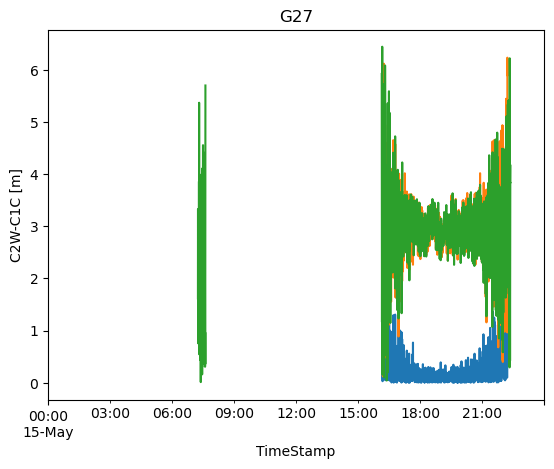

In [139]:
lcRDN1 = gpsDf_RDN1['G03'][['C1C', 'C2W']] @ np.array([ - 1, 1]).T
lcNOR3 = gpsDf_NOR3['G03'][['C1C', 'C2W']] @ np.array([ - 1, 1]).T
lcNORG = gpsDf_NORG['G03'][['C1C', 'C2W']] @ np.array([ - 1, 1]).T
lc= abs(lcRDN1-lcNOR3)
lc2= abs(lcRDN1-lcNORG)
lc3= abs(lcNOR3-lcNORG)
lc.plot(title='G03', ylabel='C2W-C1C [m]')
lc2.plot(title='G27', ylabel='C2W-C1C [m]')
lc3.plot(title='G27', ylabel='C2W-C1C [m]')


In [112]:
import numpy as np
import pandas as pd

# Assuming gpsDf_RDN1, gpsDf_NOR3, and gpsDf_NORG are your DataFrames with the satellite data
# gpsDf_RDN1 = pd.read_csv('rdn1.csv')  # Load your data if it's not already in memory
# gpsDf_NOR3 = pd.read_csv('nor3.csv')
# gpsDf_NORG = pd.read_csv('norg.csv')

# Dictionary to store the smallest differences for each satellite
differences = {}

for i in range(1, 33):  # There are 32 satellites
    satellite = f'G{i:02d}'  # Generates satellite names G01, G02, ..., G32
    
    lcRDN1 = gpsDf_RDN1[satellite][['C1C', 'C2W']] @ np.array([-1, 1]).T
    lcNOR3 = gpsDf_NOR3[satellite][['C1C', 'C2W']] @ np.array([-1, 1]).T
    lcNORG = gpsDf_NORG[satellite][['C1C', 'C2W']] @ np.array([-1, 1]).T
    
    lc = abs(lcRDN1.dropna(how='all') - lcNOR3.dropna(how='all'))
    lc2 = abs(lcRDN1.dropna(how='all') - lcNORG.dropna(how='all'))
    lc3 = abs(lcNOR3.dropna(how='all') - lcNORG.dropna(how='all'))
    
    # Find the smallest absolute difference for the current satellite
    min_diff = min(lc.mean(), lc2.mean(), lc3.mean())
    
    # Store the smallest difference in the dictionary
    differences[satellite] = min_diff

# Find the satellite with the smallest difference
smallest_diff_satellite = min(differences, key=differences.get)
smallest_diff = differences[smallest_diff_satellite]

print(f'The satellite with the smallest difference is {smallest_diff_satellite} with a difference of {smallest_diff}')


The satellite with the smallest difference is G27 with a difference of 0.21881818182899587


mmat= [[-1  1  0]
 [-1  0  1]
 [ 0 -1  1]]
TimeStamp
2022-05-15 16:09:30    0.316
2022-05-15 16:09:45    1.959
2022-05-15 16:10:00    2.126
2022-05-15 16:10:15    0.882
2022-05-15 16:10:30    0.093
                       ...  
2022-05-15 22:12:15    0.097
2022-05-15 22:12:30    2.104
2022-05-15 22:12:45    0.451
2022-05-15 22:13:00    4.130
2022-05-15 22:13:15    3.980
Length: 1456, dtype: float64


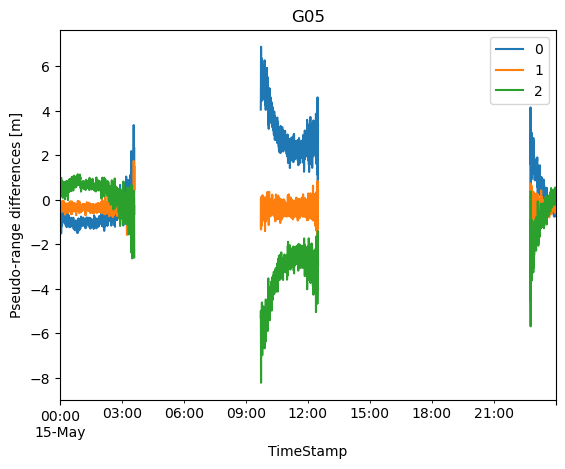

In [141]:
mmat = np.array([ [ -1, 1, 0 ], [ -1, 0, 1], [ 0, -1, 1] ])
print('mmat=',mmat)

lc_RDN1 = gpsDf_RDN1['G05'][['C1C', 'C2W', 'C1W']] @ mmat.T
lc_NOR3 = gpsDf_NOR3['G05'][['C1C', 'C2W', 'C1W']] @ mmat.T
lc_NORG = gpsDf_NORG['G05'][['C1C', 'C2W', 'C1W']] @ mmat.T
print(lc.dropna(how='all'))
ax=lc_RDN1.plot(title='G05', ylabel='Pseudo-range differences [m]')



                     C2W-C1C  C1W-C1C  C1W-C2W
TimeStamp                                     
2022-05-15 00:00:00   -3.381   -0.575    2.806
2022-05-15 00:00:15   -3.616   -0.525    3.091
2022-05-15 00:00:30   -3.336   -0.583    2.753
2022-05-15 00:00:45   -3.283   -0.334    2.949
2022-05-15 00:01:00   -3.635   -0.666    2.969
...                      ...      ...      ...
2022-05-15 23:58:45   -2.789   -0.100    2.689
2022-05-15 23:59:00   -3.316   -0.426    2.890
2022-05-15 23:59:15   -2.529    0.113    2.642
2022-05-15 23:59:30   -3.374   -0.473    2.901
2022-05-15 23:59:45   -2.632    0.008    2.640

[2041 rows x 3 columns]


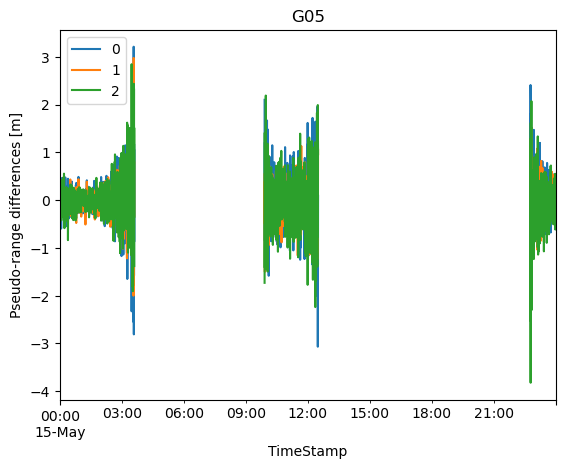

In [82]:
difRDN1_NOR3 = lc_RDN1 - lc_NOR3
print(lc.dropna(how='all'))
ax=difRDN1_NOR3.plot(title='G05', ylabel='Pseudo-range differences [m]')

The second example requires some further work to get the legend correct. This is not a concern, because there is a third - more elegant - method. Instead of multiplying with a `numpy` matrix, we multiply with another pandas DataFrame, with all the labels correct.

In [142]:
LCmat = pd.DataFrame( [ [ -1, 1, 0 ], [ -1, 0, 1], [ 0, -1, 1] ],
            columns=['C1C', 'C2W', 'C1W'],
            index=['C2W-C1C', 'C1W-C1C', 'C1W-C2W'])
LCmat

,C1C,C2W,C1W
C2W-C1C,-1,1,0
C1W-C1C,-1,0,1
C1W-C2W,0,-1,1


The result of the multiplication is now a DataFrame with correct column names.

To put everything together and plot

<AxesSubplot:title={'center':'RDN1 G05'}, xlabel='TimeStamp', ylabel='Pseudo-range differences [m]'>

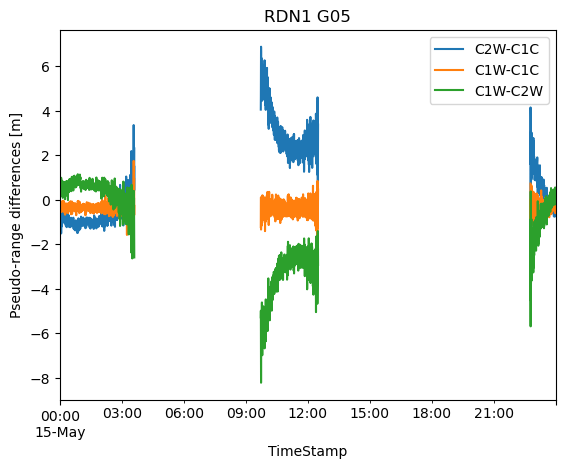

In [143]:
lc = gpsDf_RDN1['G05'][['C1C', 'C2W', 'C1W']] @ LCmat.T
lc.plot(title='RDN1 G05', ylabel='Pseudo-range differences [m]')

<AxesSubplot:title={'center':'NOR3 G05'}, xlabel='TimeStamp', ylabel='Pseudo-range differences [m]'>

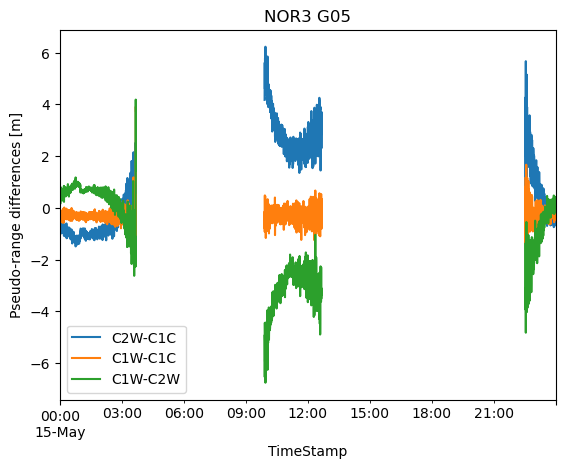

In [78]:
lc = gpsDf_NOR3['G05'][['C1C', 'C2W', 'C1W']] @ LCmat.T
lc.plot(title='NOR3 G05', ylabel='Pseudo-range differences [m]')

<AxesSubplot:title={'center':'NOR3 G05'}, xlabel='TimeStamp', ylabel='Pseudo-range differences [m]'>

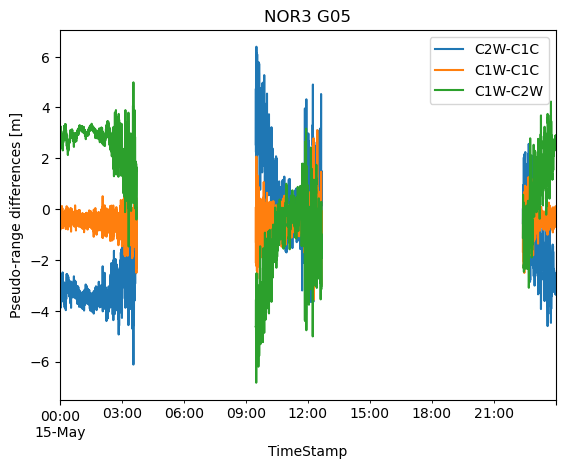

In [144]:
lc = gpsDf_NORG['G05'][['C1C', 'C2W', 'C1W']] @ LCmat.T
lc.plot(title='NOR3 G05', ylabel='Pseudo-range differences [m]')

What you are actually seeing in the `C2X-C2W` is the pseudo-range and multipath error of both measurements, because the range and ionosphere delay are the same for both. The two other combinations, `C2_-C1C`, include also the difference in ionosphere delay between the L1 and L2 frequency (ionosphere delay is dispersive and proportional to the reciprocal of the frequency squared). 

## Ionosphere delay plots

Compute the ionosphere delay using code-phase, code-code, and phase-phase linear combinations, for one of the GPS satellites. 

Plot these in one plot, using three subplots, or using different colors/symbols in the same plot.  The best representation may depend on the data your analysing. 

The following piece of code computes a DataFrame that we can use to compute the ionosphere linear combinations

* `ICL1` single frequency code-phase combination on L1
* `IC12` dual frequency code-code combination using L1 and L2 pseudo-range measurements
* `IL12` dual frequency phase-phase combination using L1 and L2 carrier-phase measurements

In [197]:
# sourceTypes = ['C1C', 'L1C', 'C2W', 'L2W']
# targetTypes = ['ICL1', 'IC12', 'IL12']

# wvl = rnxGetFreqs(['L1' , 'L2'],'G',wavelength=True)
# f = rnxGetFreqs(['L1' , 'L2'],'G')

# g12 = f['L2']**2 / f['L1']**2
# u12 = f['L2']**2 / ( f['L1']**2 - f['L2']**2 )

# mmat = [ np.array([  0.5, -0.5*wvl['L1'],   0., 0. ]) , 
#          np.array([ -u12,  0.           , u12 , 0. ]) , 
#          np.array([  0. ,  u12*wvl['L1'],   0., -u12*wvl['L2'] ]) ]

# LCmat = pd.DataFrame(mmat,columns=sourceTypes,index=targetTypes)

sourceTypes = ['C1C', 'L1C', 'C2W', 'L2W']
targetTypes = ['IC12']

wvl = rnxGetFreqs(['L1' , 'L2'],'G',wavelength=True)
f = rnxGetFreqs(['L1' , 'L2'],'G')

g12 = f['L2']**2 / f['L1']**2
u12 = f['L2']**2 / ( f['L1']**2 - f['L2']**2 )

mmat = [  np.array([ -u12,  0.           , u12 , 0. ]) ]

LCmat = pd.DataFrame(mmat,columns=sourceTypes,index=targetTypes)



In [198]:
LCmat

,C1C,L1C,C2W,L2W
IC12,-1.545728,0.0,1.545728,0.0


In [199]:
#RDN1 station
lc_stacked_RDN1 = gpsDf_stacked_RDN1[sourceTypes] @ LCmat.T
lc_stacked_RDN1 

IC12
TimeStamp           SatId          
2022-05-15 00:00:00 G11    0.794504
                    G07   -3.165650
                    G09    2.822499
                    G02   -2.769944
                    G13    0.052555
...                             ...
2022-05-15 23:59:45 G02   -1.837870
                    G05   -0.746587
                    G11    1.123744
                    G07   -2.955432
                    G30    3.306312

[53359 rows x 1 columns]

In [200]:
#NOR3 station
lc_stacked_NOR3 = gpsDf_stacked_NOR3[sourceTypes] @ LCmat.T
lc_stacked_NOR3 

IC12
TimeStamp           SatId          
2022-05-15 00:00:00 G11    1.282954
                    G14    4.439330
                    G13   -1.154659
                    G09    2.938429
                    G20   -2.470073
...                             ...
2022-05-15 23:59:45 G20   -1.689480
                    G30    3.091456
                    G16    1.827050
                    G13    1.218033
                    G07   -3.241391

[57776 rows x 1 columns]

In [201]:
#NORG station
lc_stacked_NORG = gpsDf_stacked_NORG[sourceTypes] @ LCmat.T
lc_stacked_NORG 

IC12
TimeStamp           SatId          
2022-05-15 00:00:00 G11   -2.157836
                    G05   -5.226106
                    G07   -5.448690
                    G16   -5.428596
                    G13   -4.324946
...                             ...
2022-05-15 23:59:45 G20   -5.195191
                    G09   -0.684757
                    G14   -3.805582
                    G07   -4.941692
                    G05   -4.068356

[60619 rows x 1 columns]

In [202]:
def rnxUnstack(sysDf: pd.DataFrame) -> pd.DataFrame:
    """
    Function to unstack a pandas RINEX DataFrame. 
    """
    sysDf = sysDf.unstack().reorder_levels([1, 0], axis=1).sort_index(axis=1).dropna(axis=1,how='all')
    
    return sysDf

[End of Notebook - last updated: April 2024]

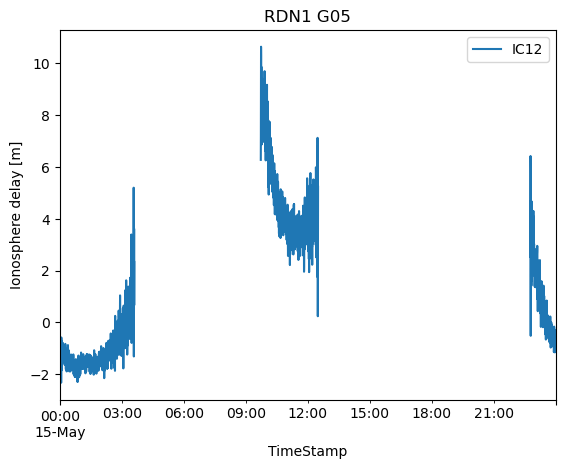

In [203]:
rnxUnstack(lc_stacked_RDN1)['G05'].plot(ylabel='Ionosphere delay [m]', title='RDN1 G05');

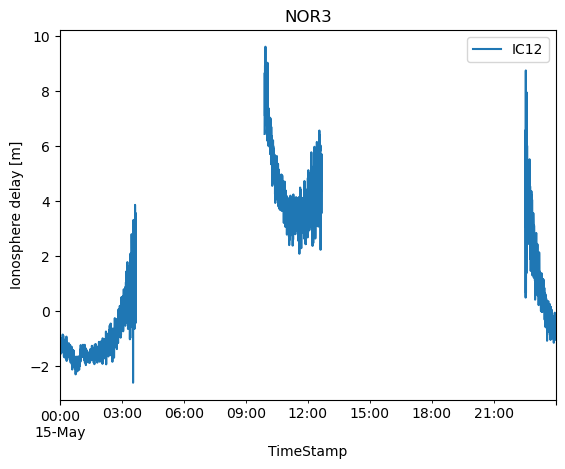

In [204]:
rnxUnstack(lc_stacked_NOR3)['G05'].plot(ylabel='Ionosphere delay [m]', title='NOR3');

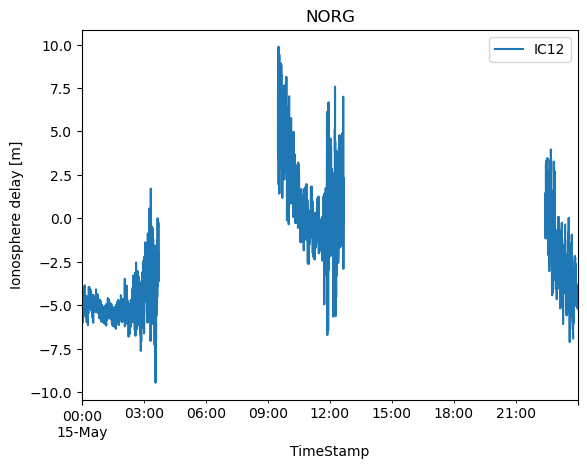

In [205]:
rnxUnstack(lc_stacked_NORG)['G05'].plot(ylabel='Ionosphere delay [m]', title='NORG');

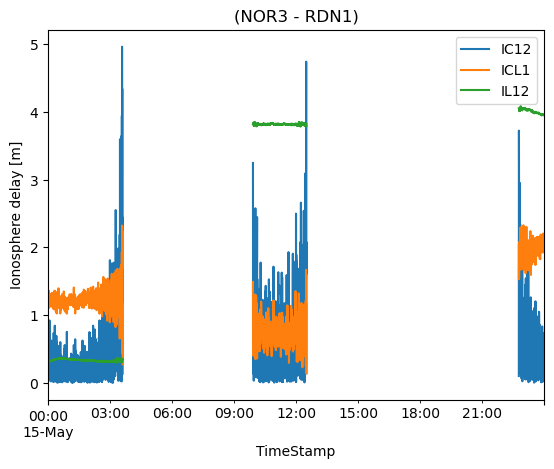

In [164]:
#difference between stations
# NOR3 - RDN1
NOR3_RDN1 = abs(lc_stacked_NOR3 - lc_stacked_RDN1)
rnxUnstack(NOR3_RDN1)['G05'].plot(ylabel='Ionosphere delay [m]', title='(NOR3 - RDN1)');

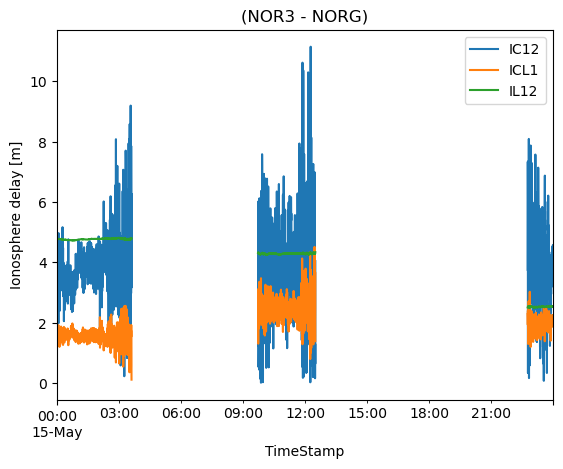

In [165]:
#difference between stations
# NOR3 - NORG
NOR3_NORG = abs(lc_stacked_NORG - lc_stacked_RDN1)
rnxUnstack(NOR3_NORG)['G05'].plot(ylabel='Ionosphere delay [m]', title='(NOR3 - NORG)');

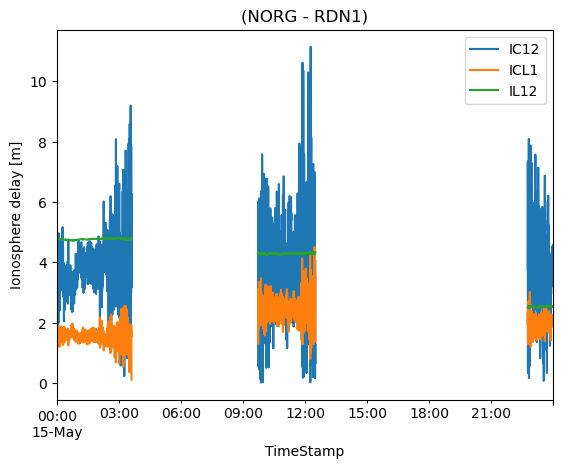

In [166]:
#difference between stations
# NORG - RDN1
NORG_RDN1 = abs(lc_stacked_NORG - lc_stacked_RDN1)
rnxUnstack(NORG_RDN1)['G05'].plot(ylabel='Ionosphere delay [m]', title='(NORG - RDN1)');

## Computing the multipath combination

geometric range and ionosphere delay are eliminated

shows the pseudo range noise and multipath noise

In [172]:
#mulit path combination 
sourceTypes = ['C1C', 'L1C', 'L2W']
targetTypes = ['M12']

wvl = rnxGetFreqs(['L1' , 'L2'],'G',wavelength=True)
f = rnxGetFreqs(['L1' , 'L2'],'G')


a12 = -(f['L1']**2 + f['L2']**2) / (f['L1']**2 - f['L2']**2)
b12 = 2*f['L2']**2 / ( f['L1']**2 - f['L2']**2 )

mmat = [ np.array([  1, a12*wvl['L1'],   b12*wvl['L2'] ]) ]



M12mat = pd.DataFrame(mmat,columns=sourceTypes,index=targetTypes)

In [173]:
#RDN1 station
M12_stacked_RDN1 = gpsDf_stacked_RDN1[sourceTypes] @ M12mat.T
M12_stacked_RDN1 

M12
TimeStamp           SatId           
2022-05-15 00:00:00 G11     5.497570
                    G07    -2.376951
                    G09    27.566465
                    G02    -7.821467
                    G13   -15.430070
...                              ...
2022-05-15 23:59:45 G02     2.575237
                    G05     8.730883
                    G11     1.205463
                    G07     1.056952
                    G30    15.433550

[53359 rows x 1 columns]

In [189]:
#NOR3 station
M12_stacked_NOR3 = gpsDf_stacked_NOR3[sourceTypes] @ M12mat.T
M12_stacked_NOR3

M12
TimeStamp           SatId           
2022-05-15 00:00:00 G11    10.307591
                    G14    -3.521544
                    G13     2.144487
                    G09     9.507789
                    G20     4.849887
...                              ...
2022-05-15 23:59:45 G20    12.444243
                    G30    15.863679
                    G16    -2.582178
                    G13    11.314991
                    G07    17.678687

[57776 rows x 1 columns]

In [190]:
#NORG station
M12_stacked_NORG = gpsDf_stacked_NORG[sourceTypes] @ M12mat.T
M12_stacked_NORG

M12
TimeStamp           SatId           
2022-05-15 00:00:00 G11    -1.785876
                    G05    -4.431729
                    G07    -0.240811
                    G16   -10.716367
                    G13    -1.787916
...                              ...
2022-05-15 23:59:45 G20    -0.765668
                    G09    -2.335129
                    G14   -12.932002
                    G07    -1.212301
                    G05    -0.614574

[60619 rows x 1 columns]

In [182]:
rnxUnstack(M12_stacked_RDN1)['G05']


,M12
TimeStamp,
2022-05-15 00:00:00,8.449632
2022-05-15 00:00:15,8.394584
2022-05-15 00:00:30,8.374635
2022-05-15 00:00:45,8.415402
2022-05-15 00:01:00,8.531283
...,...
2022-05-15 23:58:45,8.854908
2022-05-15 23:59:00,8.816767
2022-05-15 23:59:15,8.908619


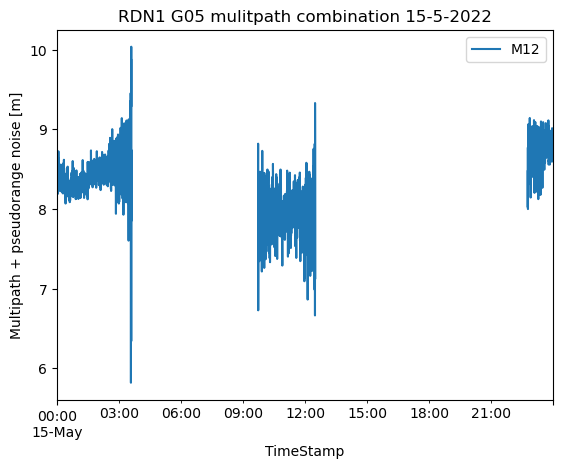

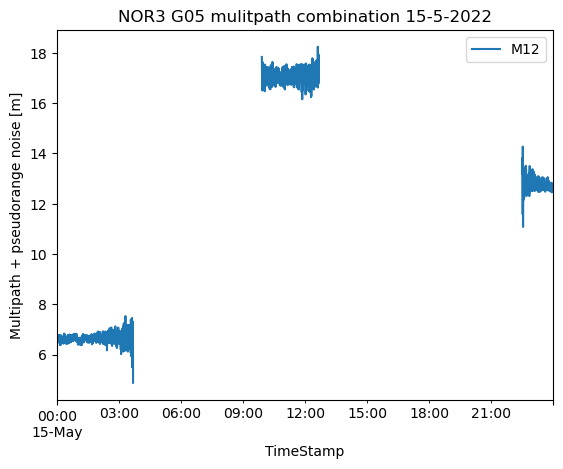

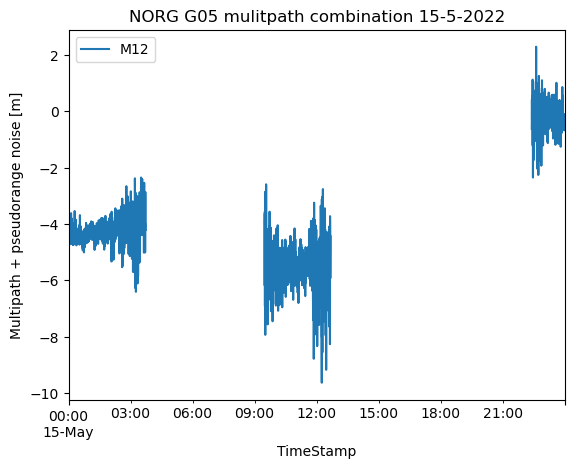

In [221]:
rnxUnstack(M12_stacked_RDN1)['G05'].plot(ylabel='Multipath + pseudorange noise [m]', title='RDN1 G05 mulitpath combination 15-5-2022');
rnxUnstack(M12_stacked_NOR3)['G05'].plot(ylabel='Multipath + pseudorange noise [m]', title='NOR3 G05 mulitpath combination 15-5-2022');
rnxUnstack(M12_stacked_NORG)['G05'].plot(ylabel='Multipath + pseudorange noise [m]', title='NORG G05 mulitpath combination 15-5-2022');


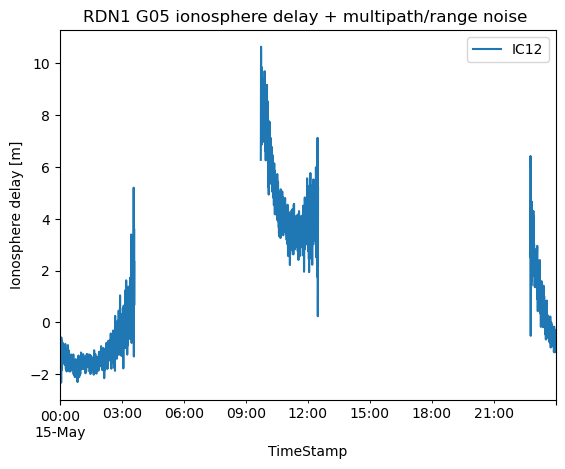

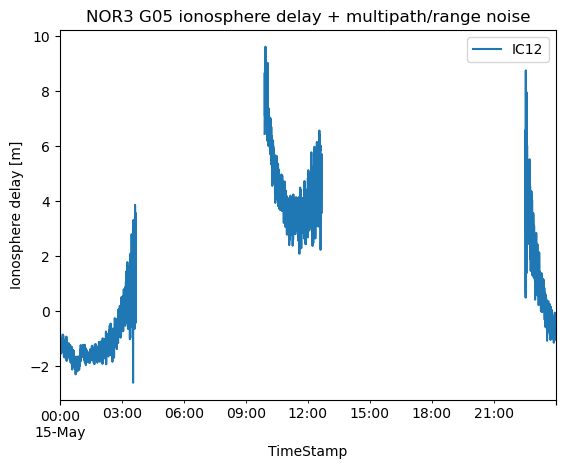

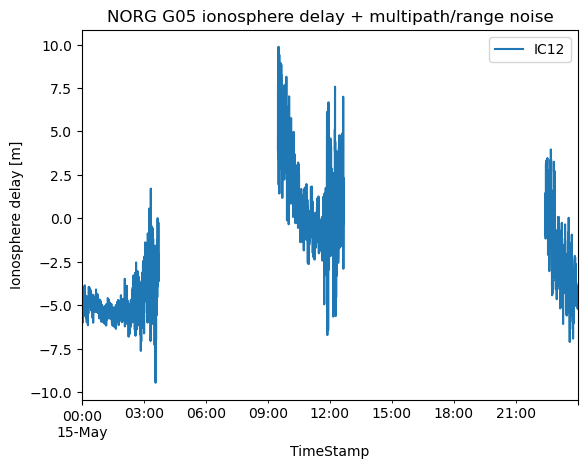

In [219]:
rnxUnstack(lc_stacked_RDN1)['G05'].plot(ylabel='Ionosphere delay [m]', title='RDN1 G05 ionosphere delay + multipath/range noise ');
rnxUnstack(lc_stacked_NOR3)['G05'].plot(ylabel='Ionosphere delay [m]', title='NOR3 G05 ionosphere delay + multipath/range noise');
rnxUnstack(lc_stacked_NORG)['G05'].plot(ylabel='Ionosphere delay [m]', title='NORG G05 ionosphere delay + multipath/range noise');

IC12  M12
TimeStamp           SatId           
2022-05-15 00:00:00 G11     NaN  NaN
                    G07     NaN  NaN
                    G09     NaN  NaN
                    G02     NaN  NaN
                    G13     NaN  NaN
...                         ...  ...
2022-05-15 23:59:45 G02     NaN  NaN
                    G05     NaN  NaN
                    G11     NaN  NaN
                    G07     NaN  NaN
                    G30     NaN  NaN

[53359 rows x 2 columns]

SatId                G01      G02      G03      G04      G05      ...  G28  \
                    IC12 M12 IC12 M12 IC12 M12 IC12 M12 IC12 M12  ... IC12   
TimeStamp                                                         ...        
2022-05-15 00:00:00  NaN NaN  NaN NaN  NaN NaN  NaN NaN  NaN NaN  ...  NaN   
2022-05-15 00:00:15  NaN NaN  NaN NaN  NaN NaN  NaN NaN  NaN NaN  ...  NaN   
2022-05-15 00:00:30  NaN NaN  NaN NaN  NaN NaN  NaN NaN  NaN NaN  ...  NaN   
2022-05-15 00:00:45  NaN NaN  NaN NaN  NaN NaN  NaN NaN  NaN NaN  ...  NaN   
2022-05-15 00:01:00  NaN NaN  NaN NaN  NaN NaN  NaN NaN  NaN NaN  ...  NaN   
...                  ...  ..  ...  ..  ...  ..  ...  ..  ...  ..  ...  ...   
2022-05-15 23:58:45  NaN NaN  NaN NaN  NaN NaN  NaN NaN  NaN NaN  ...  NaN   
2022-05-15 23:59:00  NaN NaN  NaN NaN  NaN NaN  NaN NaN  NaN NaN  ...  NaN   
2022-05-15 23:59:15  NaN NaN  NaN NaN  NaN NaN  NaN NaN  NaN NaN  ...  NaN   
2022-05-15 23:59:30  NaN NaN  NaN NaN  NaN NaN  NaN NaN  NaN NaN  ...  NaN   
2022-05-15 23:59:45  NaN NaN  NaN NaN  NaN NaN  NaN NaN  NaN NaN  ...  NaN   

SatId                    G29      G30      G31      G32      
                    M12 IC12 M12 IC12 M12 IC12 M12 IC12 M12  
TimeStamp                                                    
2022-05-15 00:00:00 NaN  NaN NaN  NaN NaN  NaN NaN  NaN NaN  
2022-05-15 00:00:15 NaN  NaN NaN  NaN NaN  NaN NaN  NaN NaN  
2022-05-15 00:00:30 NaN  NaN NaN  NaN NaN  NaN NaN  NaN NaN  
2022-05-15 00:00:45 NaN  NaN NaN  NaN NaN  NaN NaN  NaN NaN  
2022-05-15 00:01:00 NaN  NaN NaN  NaN NaN  NaN NaN  NaN NaN  
...                  ..  ...  ..  ...  ..  ...  ..  ...  ..  
2022-05-15 23:58:45 NaN  NaN NaN  NaN NaN  NaN NaN  NaN NaN  
2022-05-15 23:59:00 NaN  NaN NaN  NaN NaN  NaN NaN  NaN NaN  
2022-05-15 23:59:15 NaN  NaN NaN  NaN NaN  NaN NaN  NaN NaN  
2022-05-15 23:59:30 NaN  NaN NaN  NaN NaN  NaN NaN  NaN NaN  
2022-05-15 23:59:45 NaN  NaN NaN  NaN NaN  NaN NaN  NaN NaN  

[5760 rows x 64 columns]

In [214]:
rnxUnstack(lc_stacked_RDN1)

SatId,G01,G02,G03,G04,G05,G06,G07,G08,G09,G10,...,G23,G24,G25,G26,G27,G28,G29,G30,G31,G32
,IC12,IC12,IC12,IC12,IC12,IC12,IC12,IC12,IC12,IC12,...,IC12,IC12,IC12,IC12,IC12,IC12,IC12,IC12,IC12,IC12
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2022-05-15 00:00:00,NaN,-2.769944,NaN,NaN,-1.089738,NaN,-3.165650,NaN,2.822499,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.817862,NaN,NaN
2022-05-15 00:00:15,NaN,-3.035809,NaN,NaN,-0.717218,NaN,-3.055904,NaN,3.225934,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.936883,NaN,NaN
2022-05-15 00:00:30,NaN,-3.012623,NaN,NaN,-1.225762,NaN,-2.952340,NaN,3.440790,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.851868,NaN,NaN
2022-05-15 00:00:45,NaN,-3.286217,NaN,NaN,-1.021726,NaN,-3.617003,NaN,3.460884,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.034264,NaN,NaN
2022-05-15 00:01:00,NaN,-3.436153,NaN,NaN,-1.432890,NaN,-3.246028,NaN,3.660283,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.827136,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-15 23:58:45,NaN,-1.184027,NaN,NaN,-0.819236,NaN,-2.845685,NaN,4.471790,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.111550,NaN,NaN
2022-05-15 23:59:00,NaN,-3.259940,NaN,NaN,-0.726492,NaN,-3.187291,NaN,4.072993,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.340318,NaN,NaN


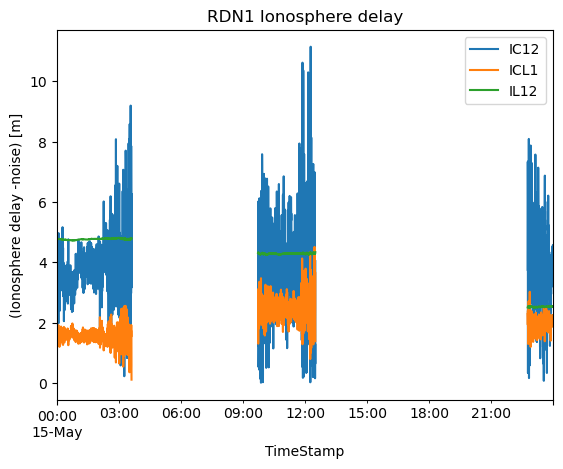

In [188]:
diff_lc_M12_RDN1 = lc_stacked_RDN1-M12_stacked_RDN1
rnxUnstack(NORG_RDN1)['G05'].plot(ylabel='(Ionosphere delay -noise) [m]', title='RDN1 Ionosphere delay');